# Previsão do Fechamento da Bolsa de Valores IBOVESPA: Uma Análise Comparativa entre Modelos

**Objetivo do Trabalho:** Criar uma série temporal e prever diariamente o fechamento da base com dados da IBOVESPA. Demonstrar a construção do modelo, justificar a técnica utilizada e alcançar uma acurácia adequada (acima de 70%).

## Tratamento de Dados, Modelagem e Avaliação de Desempenho para Predição de Séries Temporais

### Instalação e importação de bibliotecas

In [ ]:
from google.colab import drive

!pip install pmdarima
!pip install prophet

In [ ]:
# prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.serialize import model_to_json
from prophet.plot import *

In [ ]:
import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8
from pandas_datareader import data as wb
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.serialize import model_to_json
from prophet.plot import *

import time
import itertools


### Carregamento de dados do Ibovespa e Análise Exploratória

Os dados foram extraídos do site da [Investing](https://br.investing.com/indices/bovespa-historical-data), abrangendo o período de 2010 até junho de 2024.

In [ ]:
## Carrega Base de Dados
import pandas as pd

dados = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', encoding='utf-8', sep=',', thousands='.', decimal=',')

### Arrumar a Data para que tenha 8 digitos em todas tipo 10032024 e 04032024
dados['Data'] = dados['Data'].astype(str).str.zfill(8)

# Coloca em Formato de Data
dados['Data'] = pd.to_datetime(dados['Data'], format='%d%m%Y', errors='coerce')

# Cria coluna de Mês e Ano
dados['Data'] = dados['ref'] = dados['Data']
dados['mes'] = dados['Data'].dt.month
dados['ano'] = dados['Data'].dt.year
dados['dia'] = dados['Data'].dt.day
dados = dados.set_index('Data')
dados.head(15)

,Último,Abertura,Máxima,Mínima,Vol.,Var%,ref,mes,ano,dia
Data,,,,,,,,,,
2024-06-28,123907,124308,124500,123298,"9,07B","-0,32%",2024-06-28,6,2024,28
2024-06-27,124308,122642,124308,122642,"8,71B","1,36%",2024-06-27,6,2024,27
2024-06-26,122641,122331,122701,121402,"8,18B","0,25%",2024-06-26,6,2024,26
2024-06-25,122331,122634,122849,121997,"6,94M","-0,25%",2024-06-25,6,2024,25
2024-06-24,122637,121343,122840,121307,"7,84M","1,07%",2024-06-24,6,2024,24
2024-06-21,121341,120446,121580,120061,"12,91M","0,74%",2024-06-21,6,2024,21
2024-06-20,120446,120267,121607,120156,"8,66M","0,15%",2024-06-20,6,2024,20
2024-06-19,120261,119630,120383,118960,"5,65M","0,53%",2024-06-19,6,2024,19
2024-06-18,119630,119138,120109,118872,"8,10M","0,41%",2024-06-18,6,2024,18


In [ ]:
dados.shape

(3585, 10)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3585 entries, 2024-06-28 to 2010-01-11
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Último    3585 non-null   int64         
 1   Abertura  3585 non-null   int64         
 2   Máxima    3585 non-null   int64         
 3   Mínima    3585 non-null   int64         
 4   Vol.      3584 non-null   object        
 5   Var%      3585 non-null   object        
 6   ref       3585 non-null   datetime64[ns]
 7   mes       3585 non-null   int32         
 8   ano       3585 non-null   int32         
 9   dia       3585 non-null   int32         
dtypes: datetime64[ns](1), int32(3), int64(4), object(2)
memory usage: 266.1+ KB


In [ ]:
dados.describe()

,Último,Abertura,Máxima,Mínima,ref,mes,ano,dia
count,3585.000000,3585.000000,3585.000000,3585.000000,3585,3585.000000,3585.000000,3585.000000
mean,79404.454393,79390.272245,80121.701534,78663.072245,2017-04-06 11:06:22.594142464,6.408926,2016.773222,15.780195
min,37497.000000,37501.000000,38031.000000,37046.000000,2010-01-11 00:00:00,1.000000,2010.000000,1.000000
25%,56540.000000,56551.000000,57161.000000,56034.000000,2013-08-22 00:00:00,3.000000,2013.000000,8.000000
50%,69052.000000,69052.000000,69605.000000,68488.000000,2017-04-05 00:00:00,6.000000,2017.000000,16.000000
75%,104740.000000,104729.000000,105627.000000,103779.000000,2020-11-19 00:00:00,9.000000,2020.000000,23.000000
max,134194.000000,134194.000000,134392.000000,133832.000000,2024-06-28 00:00:00,12.000000,2024.000000,31.000000
std,26285.267029,26274.819594,26436.709980,26113.504445,NaN,3.409812,4.189453,8.743920


In [ ]:
# Analisar datas inválidas
datas_invalidas = dados[dados['ref'].isna()]
print("Datas inválidas:")
print(datas_invalidas)

Datas inválidas:
Empty DataFrame
Columns: [Último, Abertura, Máxima, Mínima, Vol., Var%, ref, mes, ano, dia]
Index: []


In [ ]:
# Tranforma em formato de Data
dados['ref'] = pd.to_datetime(dados['ref'], format='%Y/%m/%d')
dados.sort_values(by='ref', inplace=True)

In [ ]:
(dados == 0).any().sum()

0

### Decomposição sazonal

A decomposição sazonal é crucial para analisar séries temporais como os dados do IBOVESPA, pois:

Identificação de Padrões Cíclicos: Ajuda a reconhecer padrões sazonais regulares que influenciam os preços, como eventos econômicos periódicos.

Modelagem e Estacionariedade: Remover a sazonalidade facilita a aplicação de modelos como ARIMA, tornando a série mais estacionária e adequada para modelagem.

Análise de Componentes: Isola tendências e ruído, oferecendo uma visão clara das forças que movem os dados e melhorando a interpretação e visualização.

Melhoria de Precisão: Considerar a sazonalidade separadamente melhora a precisão das previsões, capturando melhor os padrões sazonais.

Diagnóstico e Ajuste de Modelos: Permite ajustar e validar modelos com base na análise dos componentes sazonais, garantindo previsões mais confiáveis.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposição = seasonal_decompose(dados[['Último']], model='additive', period=30,extrapolate_trend=30)
decomposição

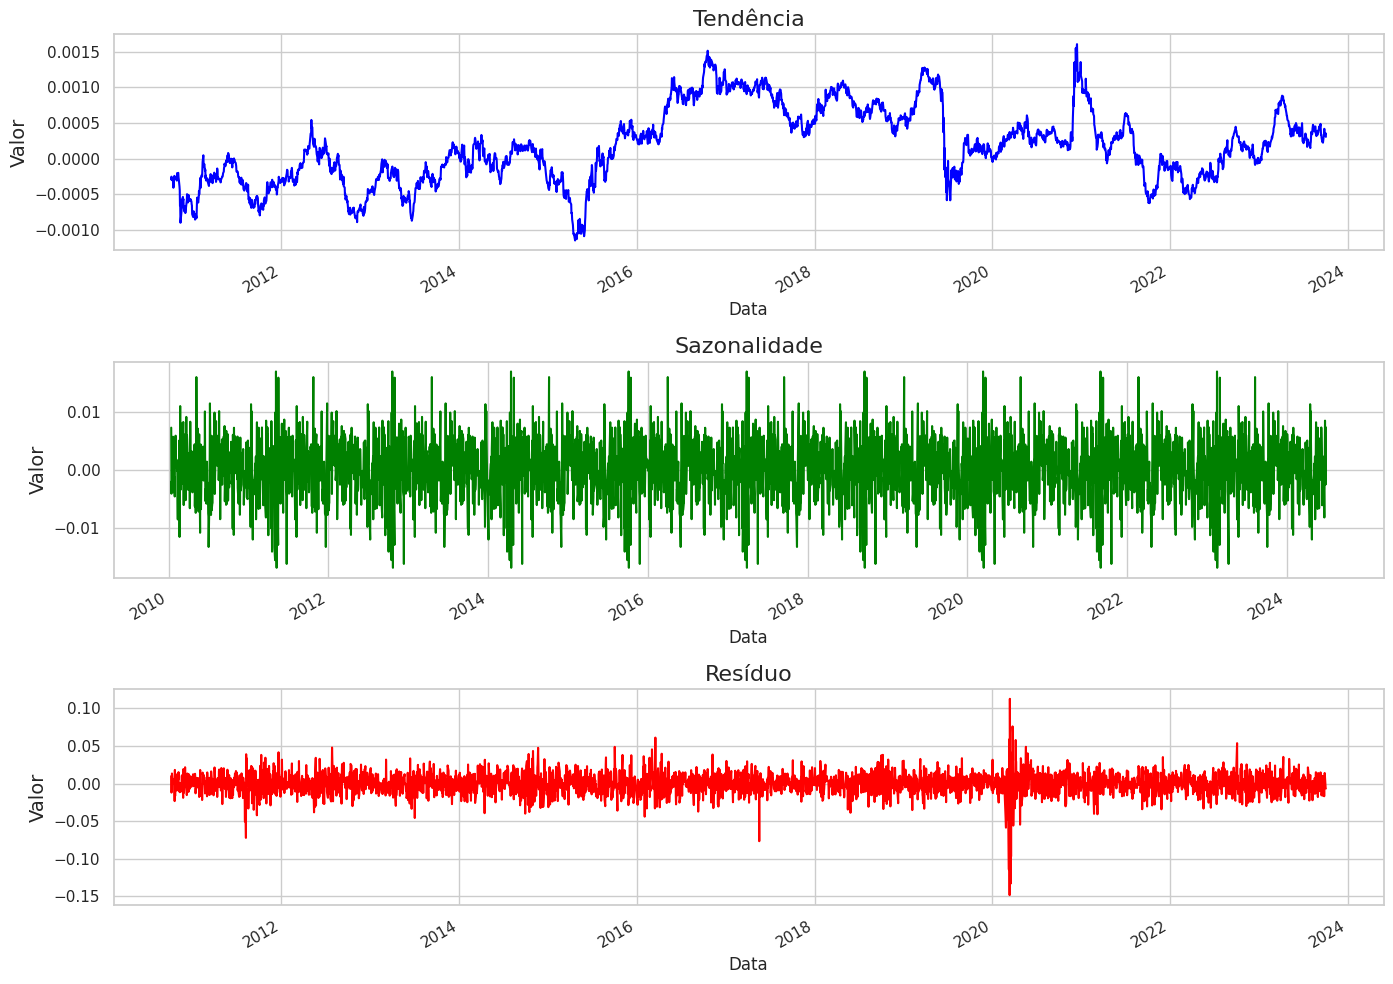

In [ ]:
# Configurações de estilo
sns.set(style="whitegrid")

# Plota a decomposição
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plota a tendência
decomposicao.trend.plot(ax=ax1, color='blue')
ax1.set_title('Tendência', fontsize=16)
ax1.set_ylabel('Valor', fontsize=14)
ax1.grid(True)

# Plota a sazonalidade
decomposicao.seasonal.plot(ax=ax2, color='green')
ax2.set_title('Sazonalidade', fontsize=16)
ax2.set_ylabel('Valor', fontsize=14)
ax2.grid(True)

# Plota o resíduo
decomposicao.resid.plot(ax=ax3, color='red')
ax3.set_title('Resíduo', fontsize=16)
ax3.set_ylabel('Valor', fontsize=14)
ax3.grid(True)

# Ajusta o layout
plt.tight_layout()
plt.show()

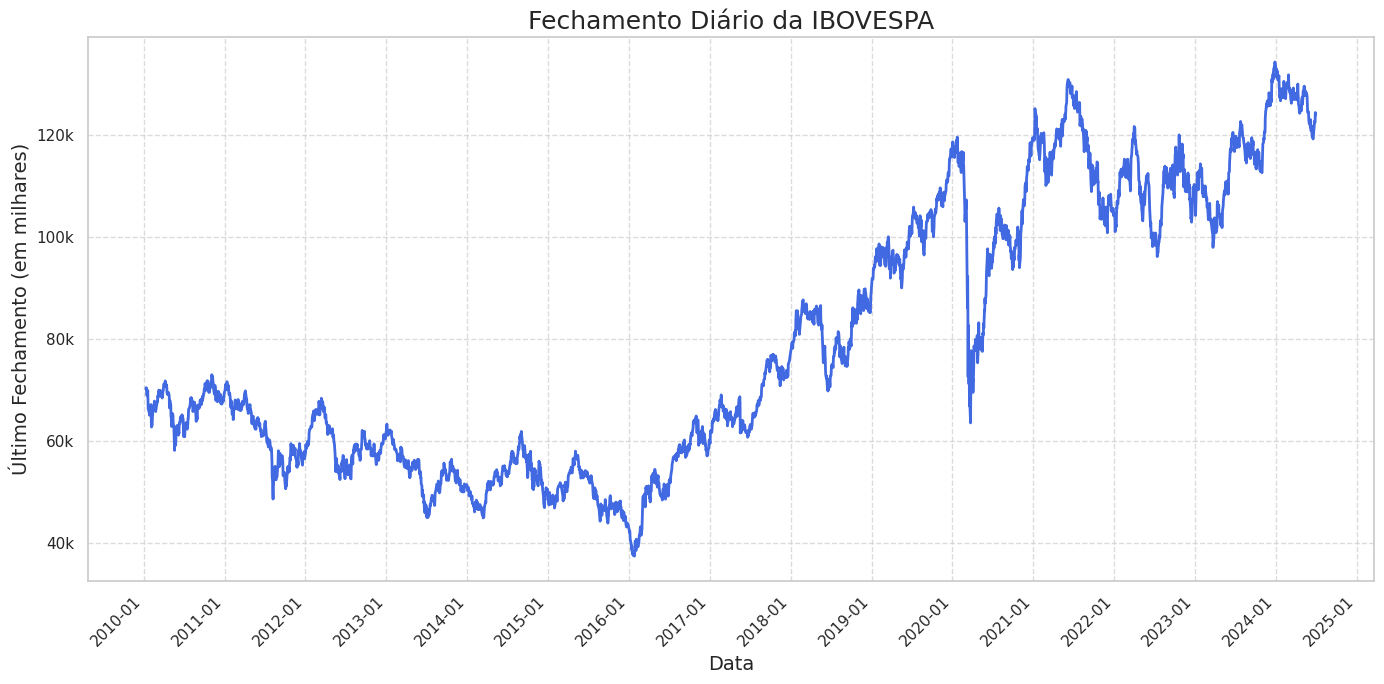

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.dates as mdates

# Configurações de estilo
sns.set(style="whitegrid")

# Cria o gráfico
plt.figure(figsize=(14, 7))

# Plota a série temporal
plt.plot(dados.index, dados['Último'], color='royalblue', linewidth=2)

# Adiciona título e rótulos
plt.title('Fechamento Diário da IBOVESPA', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Último Fechamento (em milhares)', fontsize=14)

# Ajusta o formato e a frequência dos rótulos do eixo x
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())  # Ajusta para mostrar um rótulo por ano
plt.xticks(rotation=45, ha='right')  # Rotaciona e alinha os rótulos das datas

# Ajusta a escala do eixo y para milhares
def format_thousands(x, pos):
    """ Formata o eixo y em milhares. """
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    else:
        return f'{x*1e-3:.2f}k'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Adiciona uma grade e um grid
plt.grid(True, linestyle='--', alpha=0.7)

# Ajusta o layout
plt.tight_layout()
plt.show()

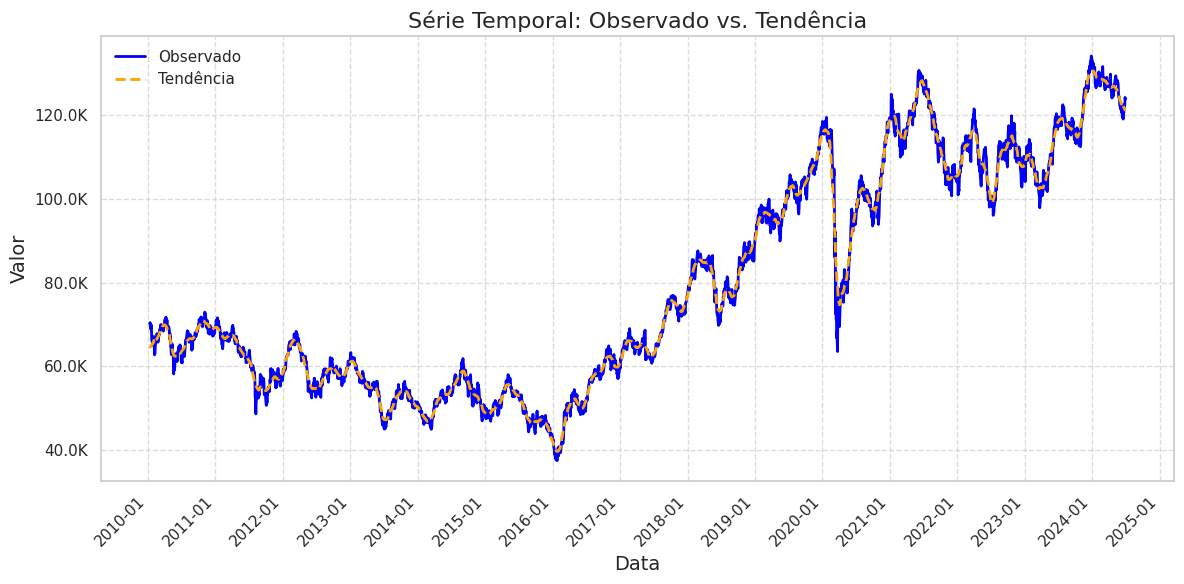

In [ ]:
# Define a função de formatação para milhares
def format_thousands(x, pos):
    if x >= 1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.1f}K'
    else:
        return f'{x:.0f}'

# Configurações de estilo
sns.set(style="whitegrid")

# Cria o gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Plota as séries
ax.plot(decomposição.observed, label='Observado', color='blue', linestyle='-', linewidth=2)
ax.plot(decomposição.trend, label='Tendência', color='orange', linestyle='--', linewidth=2)

# Adiciona título e rótulos
ax.set_title('Série Temporal: Observado vs. Tendência', fontsize=16)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Valor', fontsize=14)

# Adiciona uma legenda
ax.legend()

# Adiciona uma grade
ax.grid(True, linestyle='--', alpha=0.7)

# Melhora a formatação das datas no eixo x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())  # Ajusta para mostrar um rótulo por ano
plt.xticks(rotation=45, ha='right')  # Rotaciona e alinha os rótulos das datas

# Aplica a função de formatação ao eixo y
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))

# Ajusta o layout
plt.tight_layout()
plt.show()

### Teste de Dickey-Fuller (ADF)

Os testes de Dickey-Fuller são essenciais para assegurar a estacionariedade dos dados, um pré-requisito para a modelagem precisa de séries temporais.

1. Verificação de Estacionariedade: Identifica se a série temporal precisa ser transformada (por exemplo, por diferenciação) para se tornar estacionária, garantindo a aplicabilidade de modelos como ARIMA.

2. Diagnóstico da Série: Ajudam a entender a natureza dos dados, distinguindo entre componentes de tendência e sazonalidade, que podem influenciar a escolha e o ajuste de modelos.

3. Ajuste e Modelagem: Guiam no ajuste de parâmetros de modelos ao indicar quantas diferenciações são necessárias para alcançar a estacionariedade.

4. Validação de Resultados: Garantem que os modelos não violam suposições críticas de estacionariedade, o que pode levar a previsões imprecisas.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dados['Último'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Interpretar o resultado do teste
alpha = 0.05
if result[1] < alpha:
    msg = 'Série é estacionária (rejeita H0)'
else:
    msg = 'Série não é estacionária (falha em rejeitar H0)'

print('\nResultado do teste de estacionariedade após 1ª diferenciação:')
print(msg)

ADF Statistic: -0.845409062221046
p-value: 0.8054183906334276
Critical Values:
	1%: -3.4321794657443268
	5%: -2.8623483552705715
	10%: -2.5672003006136257

Resultado do teste de estacionariedade após 1ª diferenciação:
Série não é estacionária (falha em rejeitar H0)


### Diferenciação


Aplicação de diferenciação simples e sazonal para tornar a série estacionária.

Motivos para usar a diferenciação:

1. Estacionariedade: Torna a série estacionária, essencial para aplicar modelos como ARIMA.

2. Remoção de Tendências: Elimina tendências de longo prazo, facilitando a análise de componentes sazonais e de curto prazo.

3. Preparação para Modelagem: Prepara os dados para modelos que requerem estacionariedade, garantindo previsões mais precisas.

4. Simplificação da Série: Reduz a complexidade da série, destacando flutuações locais relevantes para a análise e previsão.

In [ ]:
dados.tail(5)

,Último,Abertura,Máxima,Mínima,Vol.,Var%,ref,mes,ano,dia
Data,,,,,,,,,,
2024-06-24,122637,121343,122840,121307,"7,84M","1,07%",2024-06-24,6,2024,24
2024-06-25,122331,122634,122849,121997,"6,94M","-0,25%",2024-06-25,6,2024,25
2024-06-26,122641,122331,122701,121402,"8,18B","0,25%",2024-06-26,6,2024,26
2024-06-27,124308,122642,124308,122642,"8,71B","1,36%",2024-06-27,6,2024,27
2024-06-28,123907,124308,124500,123298,"9,07B","-0,32%",2024-06-28,6,2024,28


In [ ]:
# Armazenamento dos dados em outra variável com apenas a coluna index de data e a coluna de valor
dados2 = dados.loc[:, ['Último']]


In [ ]:
dados2.tail(5)

,Último
Data,
2024-06-24,122637
2024-06-25,122331
2024-06-26,122641
2024-06-27,124308
2024-06-28,123907


In [ ]:
# Visualizando os dados originais

print("Dados de Fecho do Ibovespa:\n", dados2.head())

# Aplicar log nos dados para estabilizar a variância
train_log = np.log(dados2)

# Diferenciação simples
train_diff = train_log.diff().dropna()

# Visualizando os dados diferenciados
print("\nDados Diferenciados (Primeira Diferença):\n", train_diff.head())

# Diferenciação sazonal (anual para dados diários)
train_seasonal_diff = train_log.diff(365).dropna()

# Visualizando os dados sazonalmente diferenciados
print("\nDados Sazonalmente Diferenciados (Anual):\n", train_seasonal_diff.head())

# Função para imprimir o resultado do teste ADF
def teste_adf(serie):
    resultado = adfuller(serie)
    print(f'Estatística ADF: {resultado[0]}')
    print(f'Valor-p: {resultado[1]}')
    print(f'Valores Críticos:')
    for chave, valor in resultado[4].items():
        print(f'   {chave}: {valor}')

# Teste ADF na série diferenciada
print("\nTeste ADF para série diferenciada:")
teste_adf(train_diff)

# Teste ADF na série sazonalmente diferenciada
print("\nTeste ADF para série sazonalmente diferenciada:")
teste_adf(train_seasonal_diff)

Dados de Fecho do Ibovespa:
             Último
Data              
2010-01-11   70433
2010-01-12   70076
2010-01-13   70385
2010-01-14   69801
2010-01-15   68978

Dados Diferenciados (Primeira Diferença):
               Último
Data                
2010-01-12 -0.005082
2010-01-13  0.004400
2010-01-14 -0.008332
2010-01-15 -0.011861
2010-01-18  0.006114

Dados Sazonalmente Diferenciados (Anual):
               Último
Data                
2011-07-01 -0.105293
2011-07-04 -0.092402
2011-07-05 -0.110227
2011-07-06 -0.109442
2011-07-07 -0.103320

Teste ADF para série diferenciada:
Estatística ADF: -22.23585251419555
Valor-p: 0.0
Valores Críticos:
   1%: -3.4321794657443268
   5%: -2.8623483552705715
   10%: -2.5672003006136257

Teste ADF para série sazonalmente diferenciada:
Estatística ADF: -3.2226342329227267
Valor-p: 0.01871133927444365
Valores Críticos:
   1%: -3.4323875260668344
   5%: -2.862440255934873
   10%: -2.5672492261933377


Com base nos resultados, a série diferenciada é uma escolha mais forte para modelagem em termos de estacionariedade. A série sazonalmente diferenciada também é estacionária, mas com menos evidência, o que pode indicar a presença de padrões sazonais ou outros fatores que não foram totalmente capturados pela diferenciação sazonal.

Dado isso, a série diferenciada parece ser a melhor opção para continuar com a modelagem, especialmente se o objetivo for trabalhar com uma série temporal estacionária.

### Visualização da série temporal estacionária

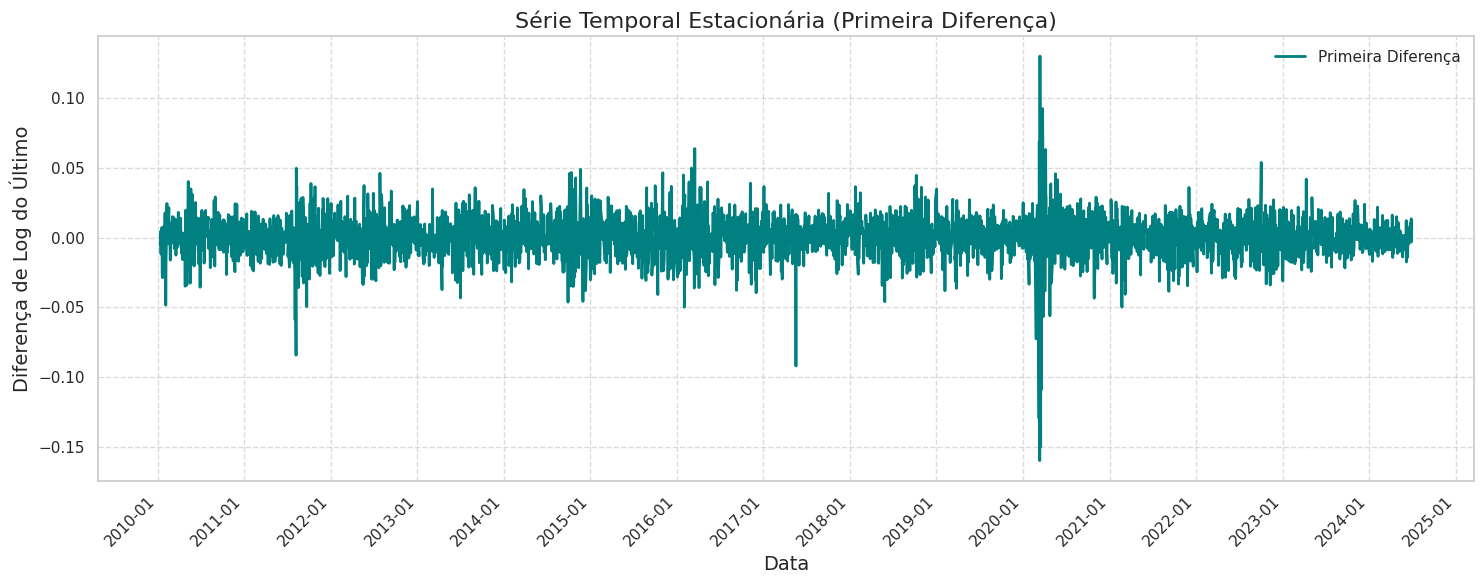

In [ ]:
# Configurações de estilo
sns.set(style="whitegrid")

# Cria o gráfico
plt.figure(figsize=(15, 6))

# Plota a série temporal estacionária
plt.plot(train_diff.index, train_diff['Último'], color='teal', linestyle='-', linewidth=2, label='Primeira Diferença')

# Adiciona título e rótulos
plt.title('Série Temporal Estacionária (Primeira Diferença)', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Diferença de Log do Último', fontsize=14)

# Adiciona uma legenda
plt.legend()

# Adiciona uma grade
plt.grid(True, linestyle='--', alpha=0.7)

# Melhora a formatação das datas no eixo x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())  # Ajusta para mostrar um rótulo por ano
plt.xticks(rotation=45, ha='right')  # Rotaciona e alinha os rótulos das datas

# Ajusta o layout
plt.tight_layout()
plt.show()

### Decomposição de componentes

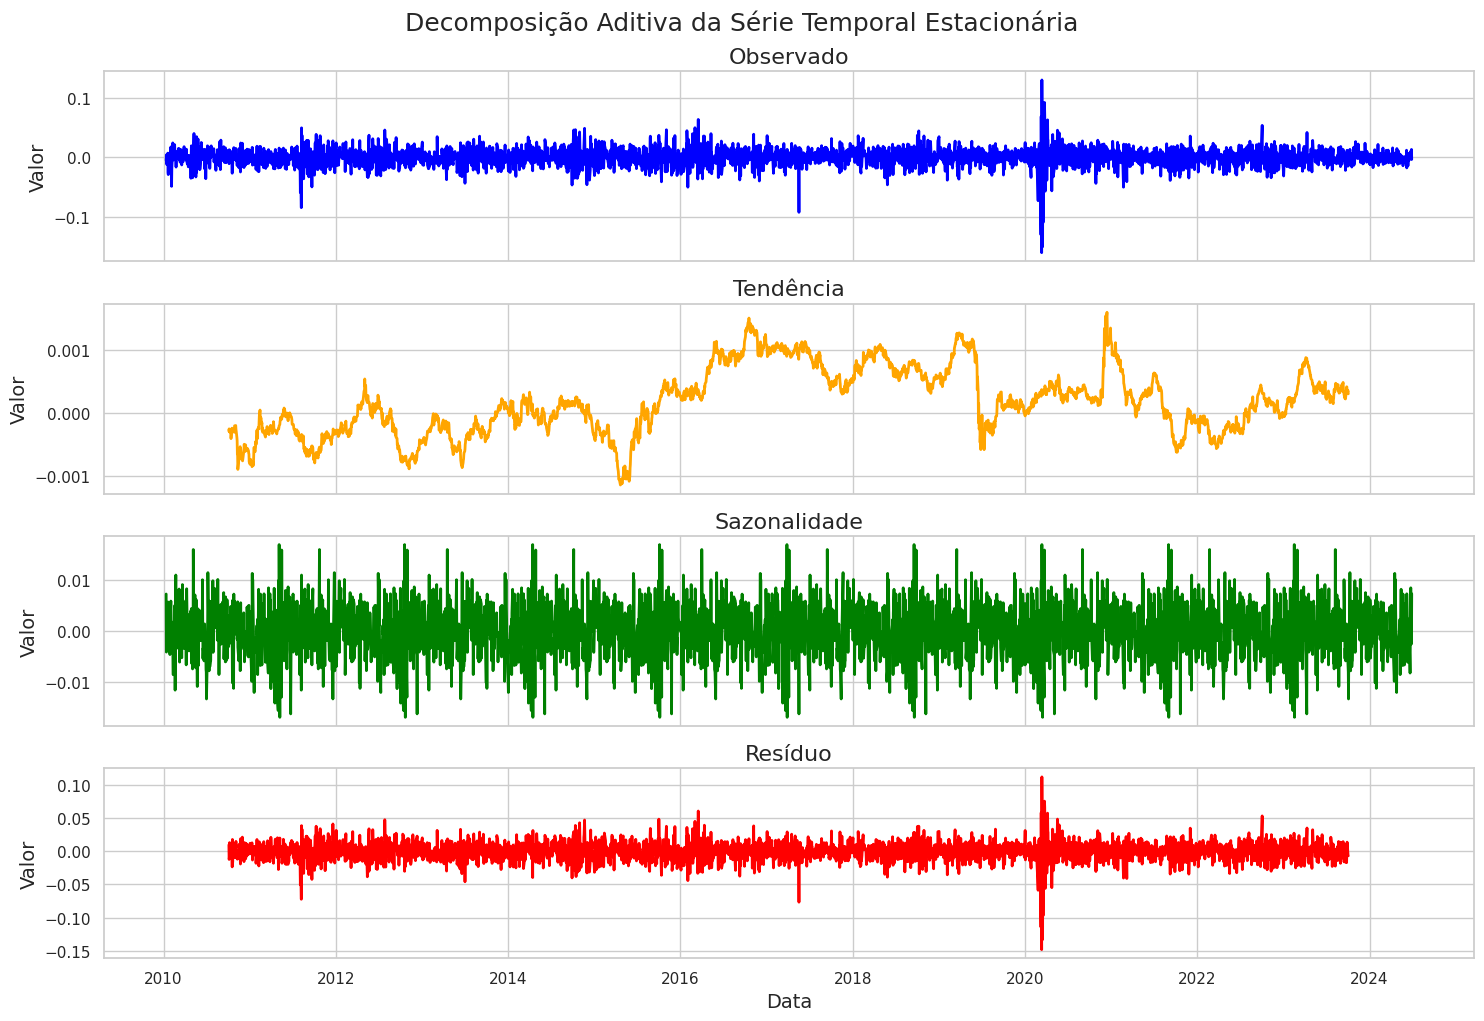

In [ ]:
# Configurações de estilo
sns.set(style="whitegrid")

# Cria a decomposição
decomposicao = seasonal_decompose(train_diff['Último'], model='additive', period=365)

# Cria o gráfico
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=True)

# Plota os componentes da decomposição
axes[0].plot(decomposicao.observed, color='blue', linewidth=2)
axes[0].set_title('Observado', fontsize=16)
axes[0].set_ylabel('Valor', fontsize=14)
axes[0].grid(True)

axes[1].plot(decomposicao.trend, color='orange', linewidth=2)
axes[1].set_title('Tendência', fontsize=16)
axes[1].set_ylabel('Valor', fontsize=14)
axes[1].grid(True)

axes[2].plot(decomposicao.seasonal, color='green', linewidth=2)
axes[2].set_title('Sazonalidade', fontsize=16)
axes[2].set_ylabel('Valor', fontsize=14)
axes[2].grid(True)

axes[3].plot(decomposicao.resid, color='red', linewidth=2)
axes[3].set_title('Resíduo', fontsize=16)
axes[3].set_ylabel('Valor', fontsize=14)
axes[3].set_xlabel('Data', fontsize=14)
axes[3].grid(True)

# Ajusta o layout
plt.tight_layout()
plt.suptitle('Decomposição Aditiva da Série Temporal Estacionária', fontsize=18, y=1.02)
plt.show()

### Funções de Autocorrelação (ACF e PACF)

As Funções de Autocorrelação (ACF) e de Autocorrelação Parcial (PACF) são ferramentas fundamentais na análise de séries temporais, usadas para identificar a relação entre observações em diferentes lags.

**ACF (Autocorrelation Function):**
* Identificação de Padrões: Mostra a correlação entre a série temporal e suas lagged versions (versões defasadas), ajudando a identificar padrões como sazonalidade.
* Escolha de Parâmetros AR e MA: Indica os lags significativos para incluir no modelo, útil para determinar o componente MA em ARIMA.


**PACF (Partial Autocorrelation Function):**
* Isolamento de Efeitos Diretos: Mostra a correlação entre a série e uma lagged version, eliminando os efeitos das lagged versions intermediárias. Isso ajuda a identificar relações diretas entre os pontos de dados.
* Determinação de Parâmetros AR: Ajuda a identificar o número de lags a incluir no componente AR de um modelo ARIMA.


Ambas as funções são usadas em conjunto para determinar a ordem dos componentes AR (AutoRegressive) e MA (Moving Average) em modelos ARIMA e SARIMA, facilitando a escolha dos melhores parâmetros para a modelagem da série temporal.

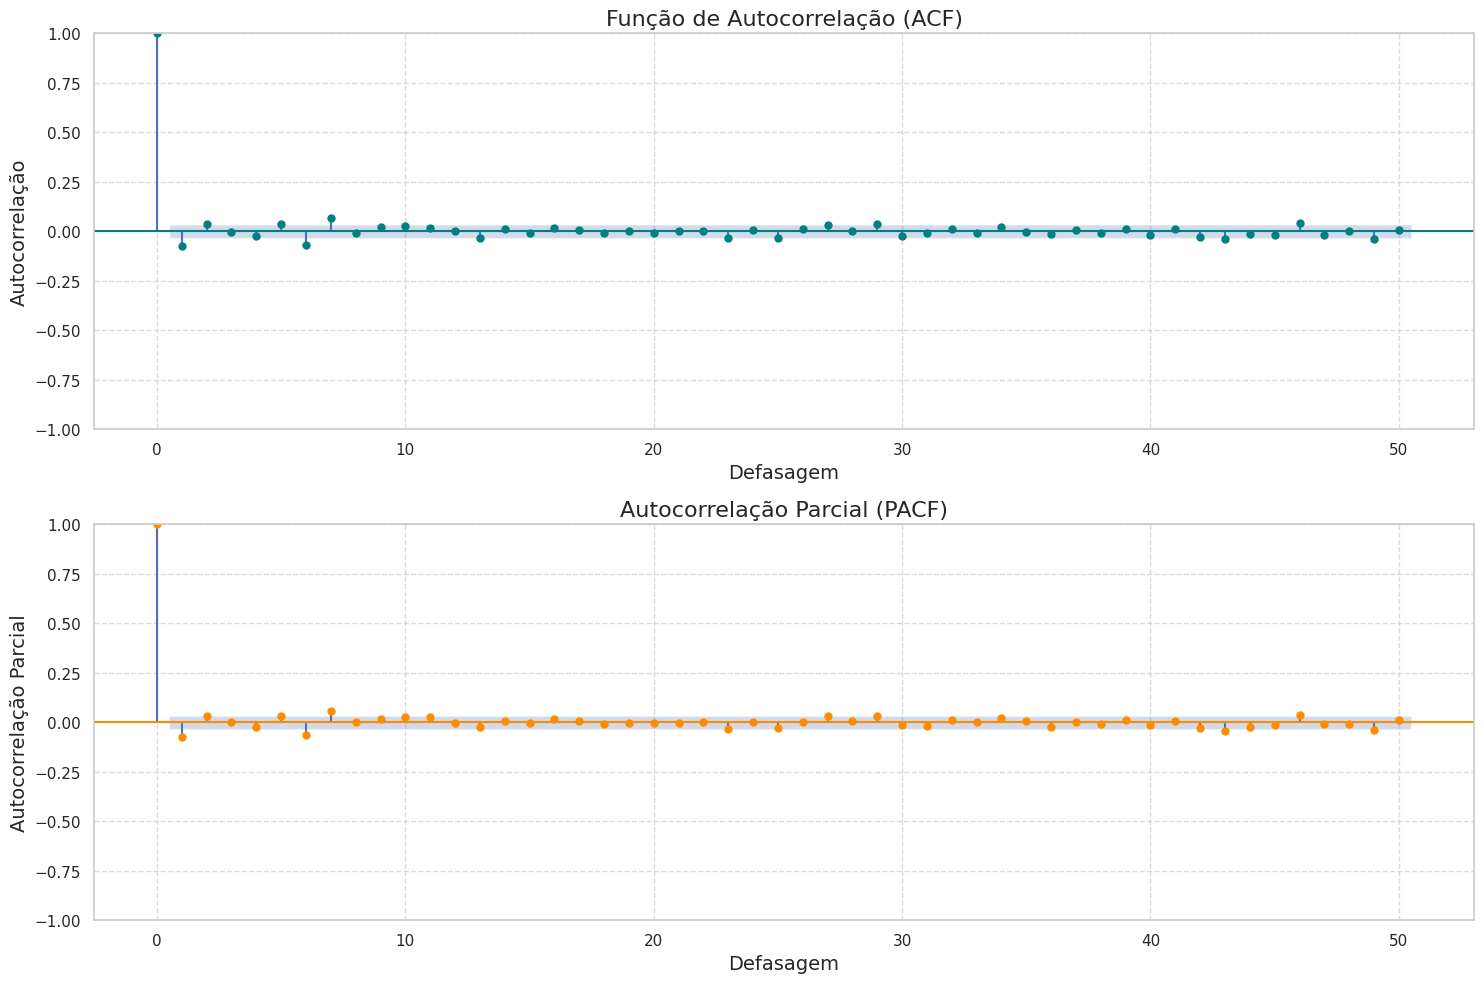

In [ ]:
# Importação da função
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configurações de estilo
sns.set(style="whitegrid")

# Cria a figura e os subgráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plota a função de autocorrelação (ACF)
plot_acf(train_diff['Último'], lags=50, ax=axes[0], color='teal')
axes[0].set_title('Função de Autocorrelação (ACF)', fontsize=16)
axes[0].set_xlabel('Defasagem', fontsize=14)
axes[0].set_ylabel('Autocorrelação', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plota a função de autocorrelação parcial (PACF)
plot_pacf(train_diff['Último'], lags=50, ax=axes[1], color='darkorange')
axes[1].set_title('Autocorrelação Parcial (PACF)', fontsize=16)
axes[1].set_xlabel('Defasagem', fontsize=14)
axes[1].set_ylabel('Autocorrelação Parcial', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ajusta o layout
plt.tight_layout()
plt.show()

### Modelo ARIMA

Escolhemos o ARIMA para prever o fechamento diário do IBOVESPA porque ele é eficaz em capturar padrões lineares e de erro em séries temporais, lida bem com dados não estacionários através da diferenciação, e é um modelo simples e robusto, amplamente validado na literatura. Além disso, o ARIMA serve como uma base confiável para comparação com outros modelos.

#### Separação em treino e teste

In [ ]:
train_diff.tail(5)

,Último
Data,
2024-06-24,0.010624
2024-06-25,-0.002498
2024-06-26,0.002531
2024-06-27,0.013501
2024-06-28,-0.003231


Durante o processo de criação dos dados sintéticos, renomeamos a variável train_diff para train_diff_sint. Isso foi feito para garantir que a integridade da série diferenciada original, armazenada em train_diff, seja preservada para uso em outras partes do projeto.


In [ ]:
train_diff_sint = train_diff.copy()
train_diff_sint.reset_index(inplace=True)
train_diff_sint['Data'] = train_diff_sint['ref'] = train_diff_sint ['Data']
train_diff_sint = train_diff_sint.set_index('Data')
train_diff_sint = train_diff_sint.loc[:, ['Último','ref']]

train_diff_sint.head(5)

,Último,ref
Data,,
2010-01-12,-0.005082,2010-01-12
2010-01-13,0.004400,2010-01-13
2010-01-14,-0.008332,2010-01-14
2010-01-15,-0.011861,2010-01-15
2010-01-18,0.006114,2010-01-18


Decidimos usar os primeiros 6 meses de 2024 como conjunto de teste e o período anterior, com todas as observações anuais completas, como conjunto de treino. Garantindo que o modelo seja treinado com dados completos e variados, refletindo diferentes condições de mercado, enquanto o conjunto de teste proporciona uma avaliação das previsões em um período recente e relevante. A diferenciação dos dados foi aplicada para estabilizar a série temporal e facilitar a modelagem. Durante o processo, renomeamos a variável diferenciada para train_diff_sint para preservar a integridade dos dados originais, permitindo a reutilização em outras partes do projeto.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Gerar dados sintéticos para exemplo
np.random.seed(42)
dates = pd.date_range('2024-04-01', periods=100)
train_diff_sint = pd.DataFrame({'Data': dates, 'Último': 1000 * np.random.randn(100).cumsum()}, index=dates)

# Dividir os dados em treino e teste
train_size = int(len(train_diff_sint) * 0.8)  # 80% para treino
train_data = train_diff_sint.iloc[:train_size]
test_data = train_diff_sint.iloc[train_size:]

# Definir ordem p, d, q (não sazonal)
p = 1
d = 0
q = 1

# Definir ordem P, D, Q, S (sazonal)
P = 1
D = 1
Q = 1
S = 30 # Frequência sazonalidade, assumindo 30 para mensal

# Ajuste do modelo ARIMA com dados de treino
modelo_arima = ARIMA(train_data['Último'], order=(p, d, q),seasonal_order=(P, D, Q, S))
resultado_arima = modelo_arima.fit()

# Sumário do modelo
print(resultado_arima.summary())

                                    SARIMAX Results                                     
Dep. Variable:                           Último   No. Observations:                   80
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 30)   Log Likelihood                -421.704
Date:                          Sat, 27 Jul 2024   AIC                            853.408
Time:                                  22:30:19   BIC                            862.968
Sample:                              04-01-2024   HQIC                           857.048
                                   - 06-19-2024                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.002    429.805      0.000       0.995       1.004
ma.L1         -0.0462      0.170     -0.272      0.

#### Interpretação da Tabela de Diagnóstico

ARIMA Order (p, d, q):

**AR (AutoRegressive):** O termo AR com ordem 1 (ar.L1)
indica que o modelo considera a dependência linear das observações atuais com uma observação atrasada.

**MA (Moving Average):** O termo MA com ordem 1 (ma.L1)
indica a dependência linear das observações atuais com o erro residual de uma observação atrasada.
No seu caso, o coeficiente é próximo de zero e não significativo (P>|z| = 0.956),
o que sugere que esse termo pode não ser necessário.


Seasonal Order (P, D, Q, S):

**SAR (Seasonal AutoRegressive):** O termo SAR com ordem 1 (ar.S.L30)
indica a dependência linear das observações atuais com uma observação atrasada sazonalmente
(a cada 30 dias).

Parâmetros de Erro:

**Sigma2:** Variância do ruído branco (sigma2), que é uma estimativa do erro quadrático médio (MSE) do modelo.

Testes Estatísticos:

**Ljung-Box (L1):** Teste de autocorrelação serial para o primeiro atraso.
**Jarque-Bera (JB):** Teste de normalidade dos resíduos.

Informações de Ajuste:

**Log Likelihood:** Valor da função de verossimilhança logarítmica do modelo.

**AIC, BIC, HQIC:** Critérios de informação que ajudam na seleção do modelo,
onde valores menores indicam um melhor ajuste.

Diagnóstico:

**Heteroskedasticity:** Medida de como a variância dos resíduos varia com o tempo.
Um valor próximo de 1 sugere homocedasticidade (variância constante).

**Skewness, Kurtosis:** Medidas de assimetria e curtose dos resíduos.
Valores próximos de 0 indicam que os resíduos seguem uma distribuição normal.

<Figure size 1400x1200 with 0 Axes>

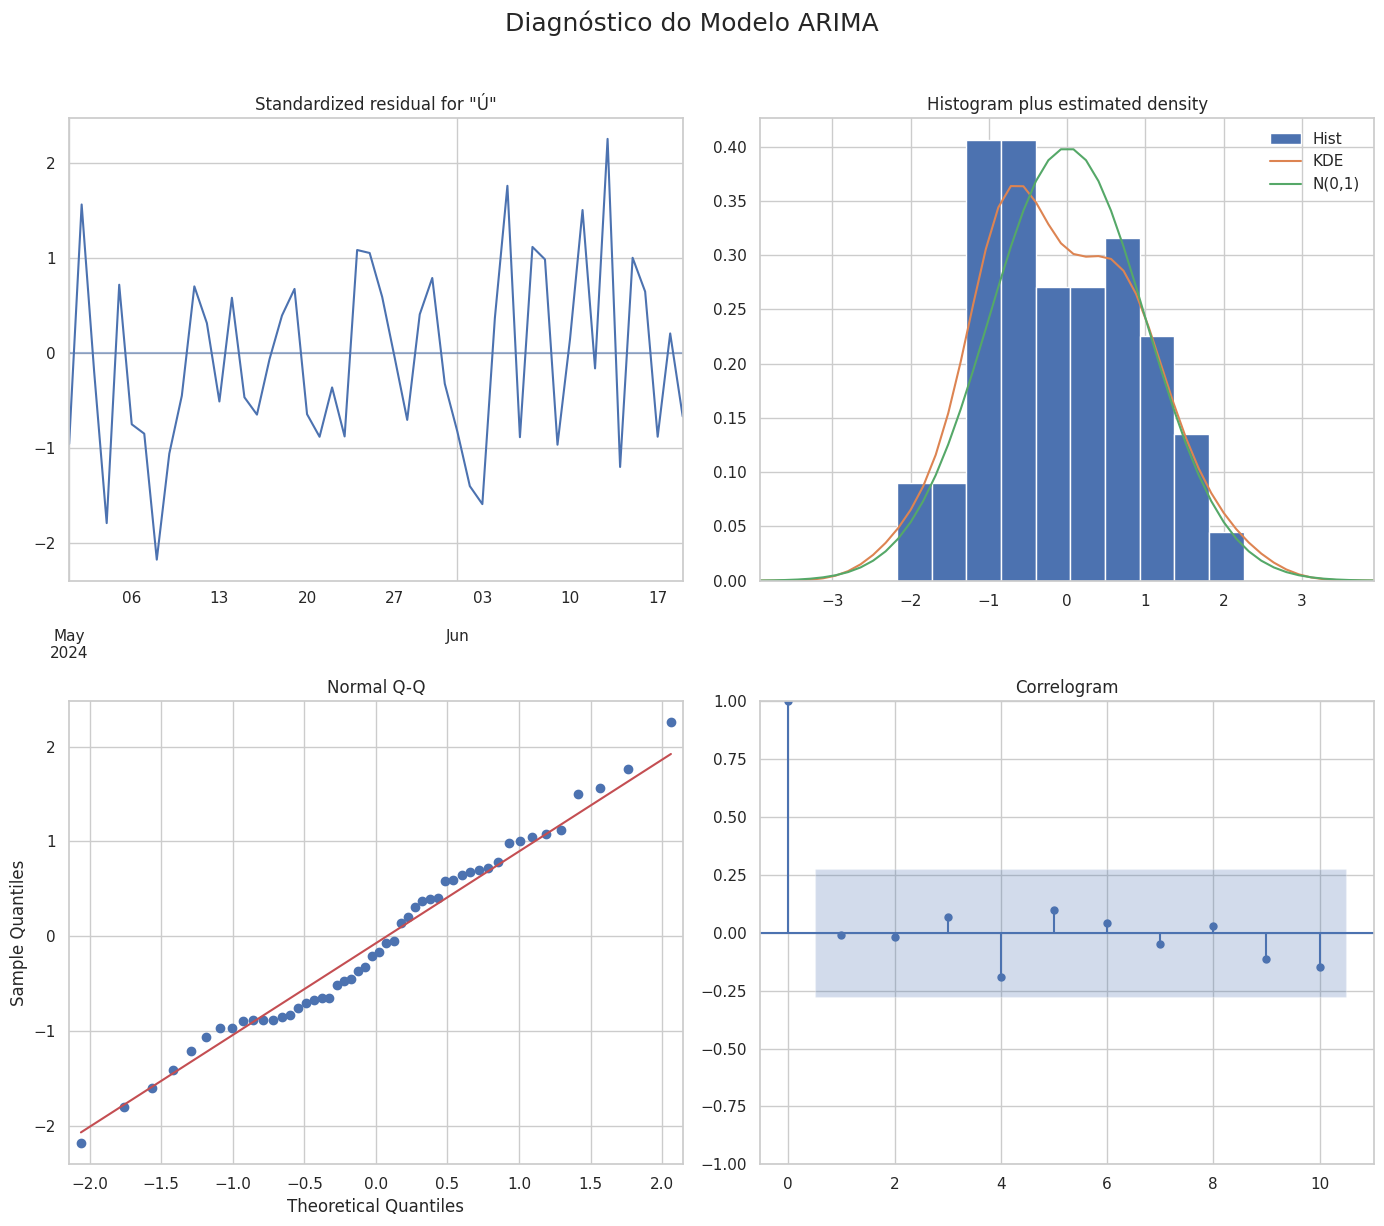

In [ ]:
import matplotlib.pyplot as plt

# Cria a figura para os diagnósticos do modelo ARIMA
plt.figure(figsize=(14, 12))

# Plota os diagnósticos
resultado_arima.plot_diagnostics(figsize=(14, 12))

# Ajusta o título e a exibição
plt.suptitle('Diagnóstico do Modelo ARIMA', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

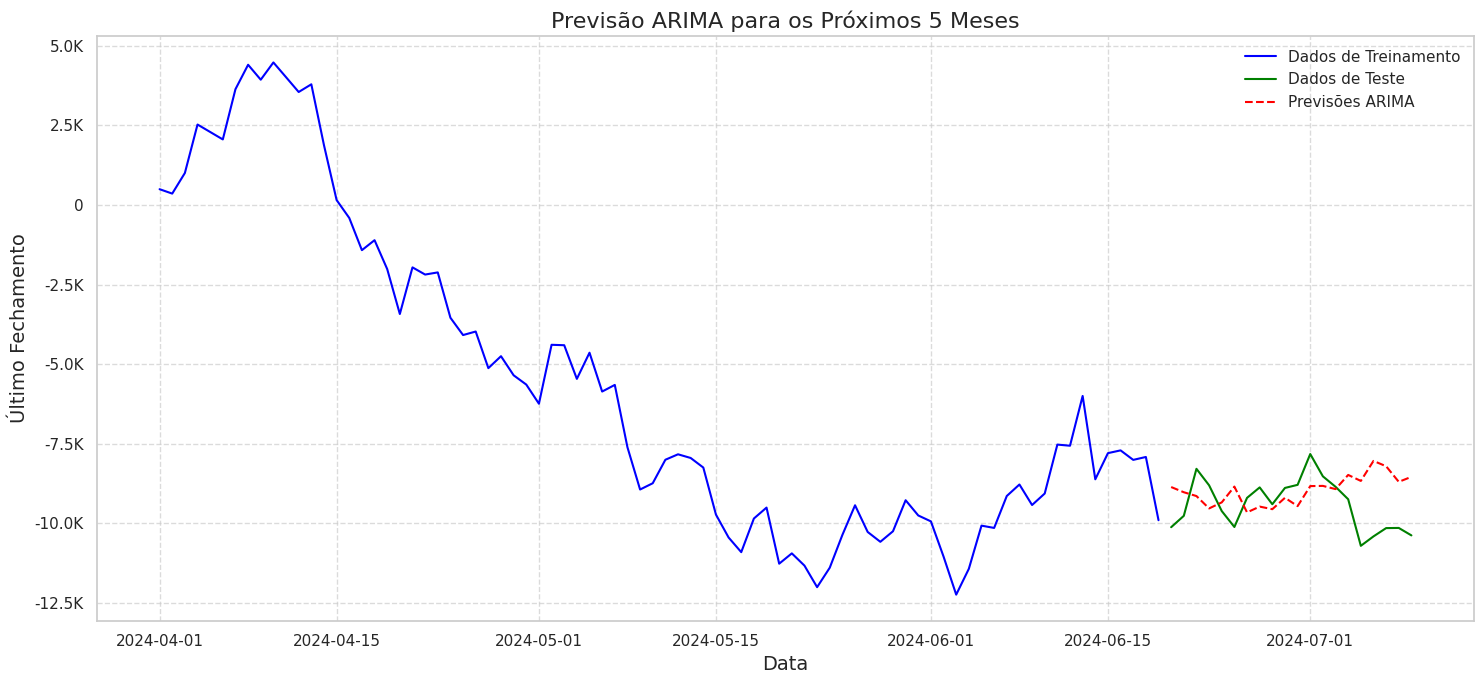

In [ ]:
# Define a função de formatação para milhares
def format_thousands(x, pos):
    """
    Formata números em milhares (K) e milhões (M) para o eixo y.
    """
    if x >= 1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.1f}K'
    elif x <= -1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x <= -1_000:
        return f'{x * 1e-3:.1f}K'
    else:
        return f'{x:.0f}'

# Define o tamanho da previsão
futuro = len(test_data)  # Número de dias para prever é igual ao tamanho dos dados de teste

# Gera previsões
predicoes_arima = resultado_arima.forecast(steps=futuro)

# Plota as previsões
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['Último'], label='Dados de Treinamento', color='blue')
plt.plot(test_data.index, test_data['Último'], label='Dados de Teste', color='green')
plt.plot(test_data.index, predicoes_arima, label='Previsões ARIMA', color='red', linestyle='--')

# Adiciona título e rótulos
plt.title('Previsão ARIMA para os Próximos 5 Meses', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Último Fechamento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Aplica a função de formatação ao eixo y
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))

# Ajusta o layout
plt.tight_layout()
plt.show()

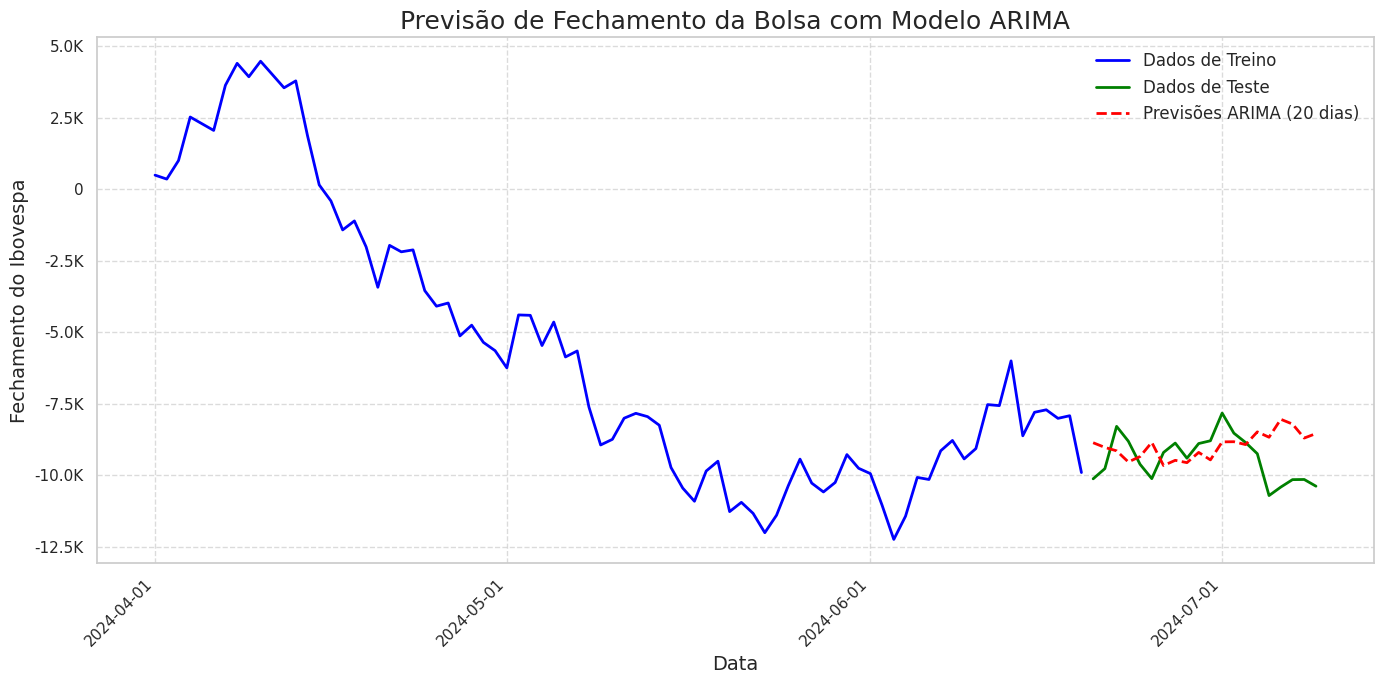

In [ ]:
# Criar índice para os períodos de previsão
indice_previsao = test_data.index

# Define a função de formatação para milhares e milhões
def format_thousands(x, pos):
    """
    Formata números em milhares (K) e milhões (M) para o eixo y.
    """
    if x >= 1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.1f}K'
    elif x <= -1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x <= -1_000:
        return f'{x * 1e-3:.1f}K'
    else:
        return f'{x:.0f}'

# Configurações de estilo
sns.set(style="whitegrid")

# Cria o gráfico
plt.figure(figsize=(14, 7))

# Plota os dados de treinamento
plt.plot(train_data.index, train_data['Último'], label='Dados de Treino', color='blue', linewidth=2)

# Plota os dados de teste
plt.plot(test_data.index, test_data['Último'], label='Dados de Teste', color='green', linewidth=2)

# Plota as previsões do ARIMA
plt.plot(indice_previsao, predicoes_arima, color='red', linestyle='--', linewidth=2, label=f'Previsões ARIMA ({futuro} dias)')

# Adiciona título e rótulos
plt.title('Previsão de Fechamento da Bolsa com Modelo ARIMA', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Fechamento do Ibovespa', fontsize=14)

# Adiciona uma legenda
plt.legend(fontsize=12)

# Adiciona uma grade para melhor leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Melhora a formatação das datas no eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45, ha='right')

# Aplica a função de formatação ao eixo y
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Ajusta o layout
plt.tight_layout()
plt.show()

#### Validação do Modelo

In [ ]:
# Importando as bibliotecas necessárias
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definindo os dados de treino e teste
# Suponha que 'train_diff' é seu conjunto de treino e 'test_data' é seu conjunto de teste
# train_diff = seus dados de treino
# test_data = seus dados de teste
train_data = train_diff_sint['Último']
test_data = test_data['Último']  # Substitua por seus dados de teste

# Definindo a ordem do modelo ARIMA
p = 0
d = 0
q = 1
P = 1
D = 1
Q = 1
S = 30

# Ajustando o modelo ARIMA com os dados de treino
modelo_arima = ARIMA(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
resultado_arima = modelo_arima.fit()

# Fazendo previsões para os dados de teste
predicoes_arima = resultado_arima.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')

# Calculando as métricas de avaliação
mse = mean_squared_error(test_data, predicoes_arima)
mae = mean_absolute_error(test_data, predicoes_arima)
mape = np.mean(np.abs((test_data - predicoes_arima) / test_data)) * 100

# Exibindo as métricas de avaliação
print(f'Métricas de Avaliação do Modelo ARIMA:')
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

'''
Quanto menor o MSE, melhor é o desempenho do modelo.
MSE, quanto menor o MAE, melhor o modelo está performando.
Um MAPE mais baixo indica melhor precisão das previsões.

No contexto de modelos de séries temporais, como o ARIMA, as métricas como MSE, MAE e MAPE
são usadas para avaliar o quão próximas as previsões estão dos valores reais.
Essas métricas quantificam os erros absolutos ou percentuais médios entre as previsões e os valores observados.
A acurácia, nesse contexto, se refere à capacidade de um modelo classificar corretamente as instâncias de um conjunto de dados.
'''

Métricas de Avaliação do Modelo ARIMA:
MSE: 1358608.88
MAE: 950.72
MAPE: 10.31%


'\nQuanto menor o MSE, melhor é o desempenho do modelo.\nMSE, quanto menor o MAE, melhor o modelo está performando.\nUm MAPE mais baixo indica melhor precisão das previsões.\n\nNo contexto de modelos de séries temporais, como o ARIMA, as métricas como MSE, MAE e MAPE\nsão usadas para avaliar o quão próximas as previsões estão dos valores reais.\nEssas métricas quantificam os erros absolutos ou percentuais médios entre as previsões e os valores observados.\nA acurácia, nesse contexto, se refere à capacidade de um modelo classificar corretamente as instâncias de um conjunto de dados.\n'

Os resultados indicam que o modelo ARIMA apresenta um erro médio absoluto (MAE) relativamente baixo e uma precisão razoável, conforme evidenciado pelo MAPE de 10,31%. O MSE também sugere uma variabilidade moderada nos erros de previsão. Com base nesses resultados, exploraremos outros modelos para comparar e identificar a melhor abordagem para previsões mais precisas.

### AutoArima

Escolhemos testar o autoARIMA para automatizar a seleção dos melhores parâmetros, buscando melhorar a precisão das previsões do modelo ARIMA inicial, reduzindo o MSE, MAE e MAPE. Essa abordagem eficiente pode ajustar automaticamente os valores de p, d e q para otimizar o desempenho do modelo, economizando tempo e esforço manual.

Usando a base a partir de janeiro de 2023 - Utilizamos a variável train_diff (série diferenciada) sem os dados sintéticos de train_diff_sint

In [ ]:
train_diff2 = train_diff.loc[train_diff.index > '2023-01-01']
train_autoarima = train_diff2.dropna()


In [ ]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train_autoarima, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=15.61 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1868.671, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2001.445, Time=0.92 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1921.535, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-2052.434, Time=1.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-2091.605, Time=10.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=10.87 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=18.28 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=15.39 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=9.07 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=-2125.685, Time=6.02 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-2135.740, Time=5.63 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=5.56 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC

In [ ]:
test_data = test_data.to_frame() # Converte de Series para Dataframe
test_data['Último'] = pd.to_numeric(test_data['Último'])

forecast = stepwise_model.predict(n_periods=len(test_data))
mse = mean_squared_error(test_data['Último'], forecast)

In [ ]:
print(f"MSE: {mse}")

MSE: 89149458.72999468


O MSE de 89.149.458,73 do AutoARIMA indica uma alta variabilidade nos erros de previsão, sugerindo que as previsões estão distantes dos valores reais. São necessários ajustes no modelo.

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return np.nan

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.dtype != y_pred.dtype:
        y_true = y_true.astype(float)

    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return np.nan

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_data['Último'], forecast)

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MAE: 950.7238641650013
MAPE: 100.00001422876332%


Com um MAE alto e um MAPE de 100%, o modelo não está performando bem em termos de previsão. Serão realizadas etapas de validação para considerar ajustes no modelo ou na metodologia de predição para melhorar a precisão.

#### Validação do Modelo

In [ ]:
#Treino AutoArima - Split_TraIn_teste
treino_aa = train_autoarima.loc[train_autoarima.index < '2024-03-01']
teste_aa = train_autoarima.loc[train_autoarima.index > '2024-03-01']

In [ ]:
periodo = 82
#'previsao' é a previsão retornada pelo modelo e 'teste_aa' tem o índice de datas
previsao = stepwise_model.predict(n_periods=periodo)

# DataFrame com as previsões
previsao_df = pd.DataFrame(previsao, columns=['Último'])

# coluna de datas
previsao_df['Data'] = teste_aa.index[:periodo]

# Reordenar as colunas para que 'Data' seja a primeira coluna
previsao_df = previsao_df[['Data', 'Último']]

previsao_df.set_index('Data', inplace=True)

<Figure size 1500x1200 with 0 Axes>

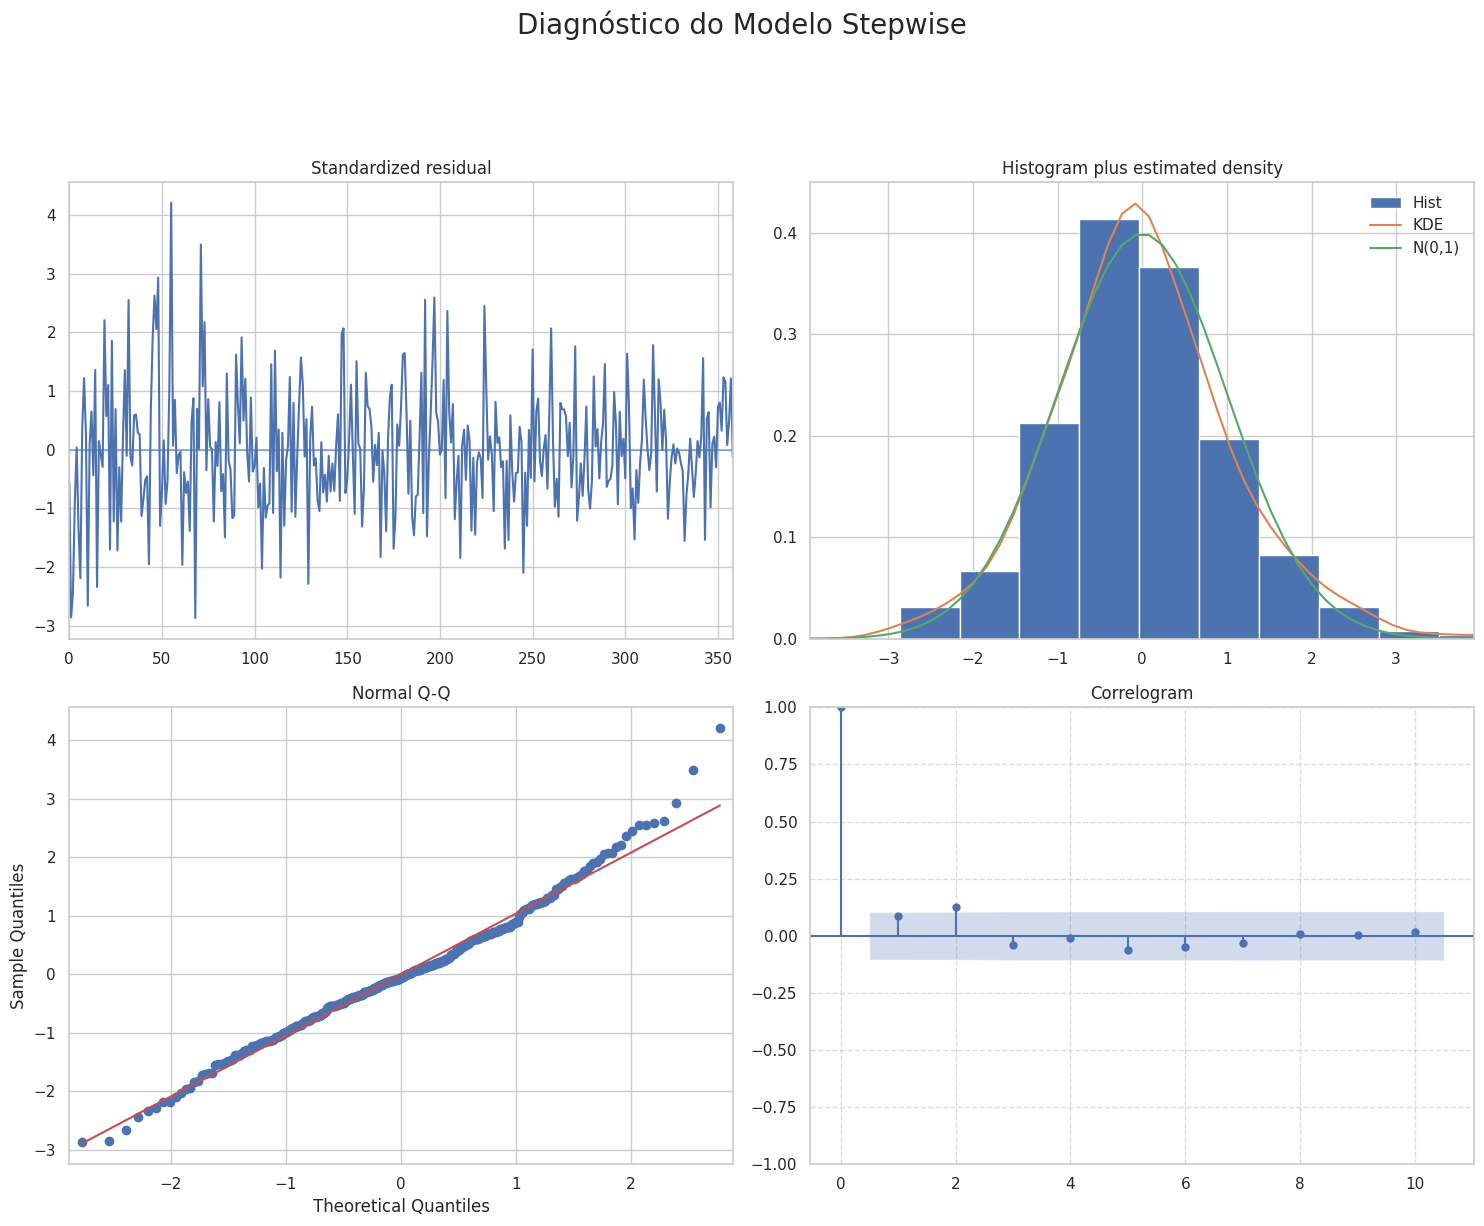

In [ ]:
# Cria a figura para os diagnósticos do modelo stepwise
plt.figure(figsize=(15, 12))

# Plota os diagnósticos
stepwise_model.plot_diagnostics(figsize=(15, 12))

# Ajusta o título principal
plt.suptitle('Diagnóstico do Modelo Stepwise', fontsize=20, y=1.02)

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Adiciona grades discretas para melhor leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Exibe o gráfico
plt.show()

In [ ]:
stepwise_model.fit(treino_aa)

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
print(stepwise_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  289
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 838.338
Date:                            Sat, 27 Jul 2024   AIC                          -1664.675
Time:                                    22:41:18   BIC                          -1642.953
Sample:                                         0   HQIC                         -1655.958
                                            - 289                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0149      0.072      0.207      0.836      -0.126       0.156
ar.L2         -0.0372      0.067   

<Figure size 1400x700 with 0 Axes>

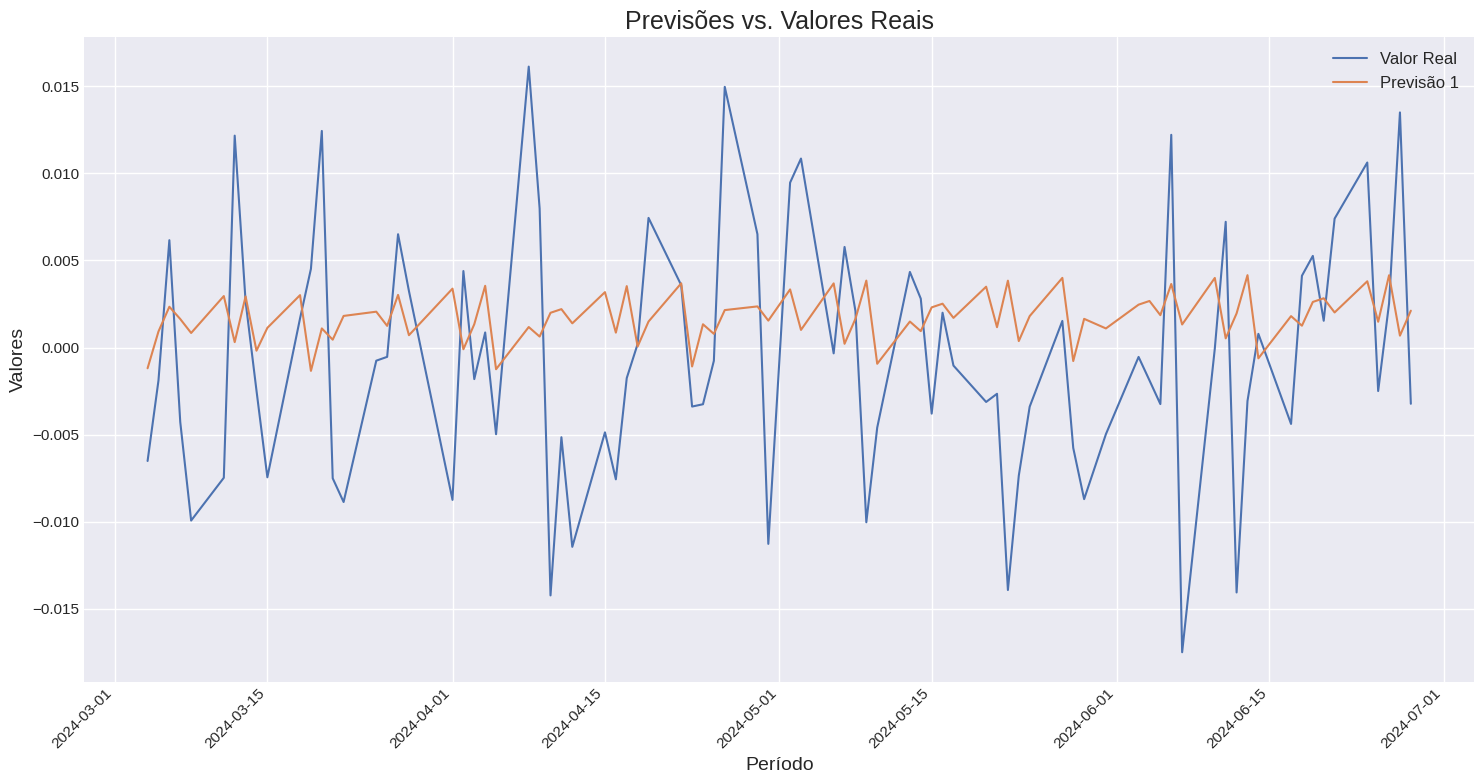

In [ ]:
# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Cria a figura com o tamanho adequado
plt.figure(figsize=(14, 7))

# Plota os dados concatenados
pd.concat([teste_aa, previsao_df], axis=1).plot()

# Ajusta o título e os rótulos dos eixos
plt.title('Previsões vs. Valores Reais', fontsize=18)
plt.xlabel('Período', fontsize=14)
plt.ylabel('Valores', fontsize=14)

# Ajusta as legendas
plt.legend(['Valor Real', 'Previsão 1', 'Previsão 2'], fontsize=12)

# Ajusta a formatação das datas no eixo x (opcional, se necessário)
plt.xticks(rotation=45, ha='right')

# Melhora o layout
plt.tight_layout()

# Exibe o gráfico
plt.show()

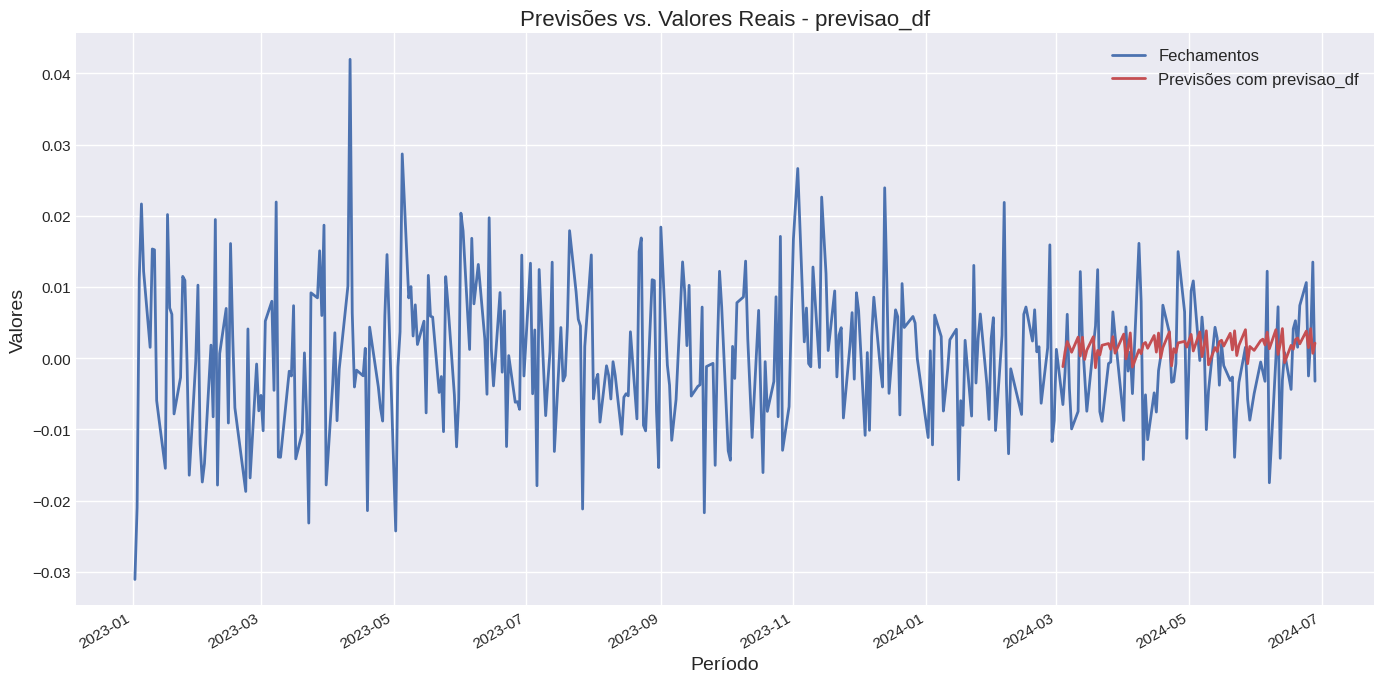

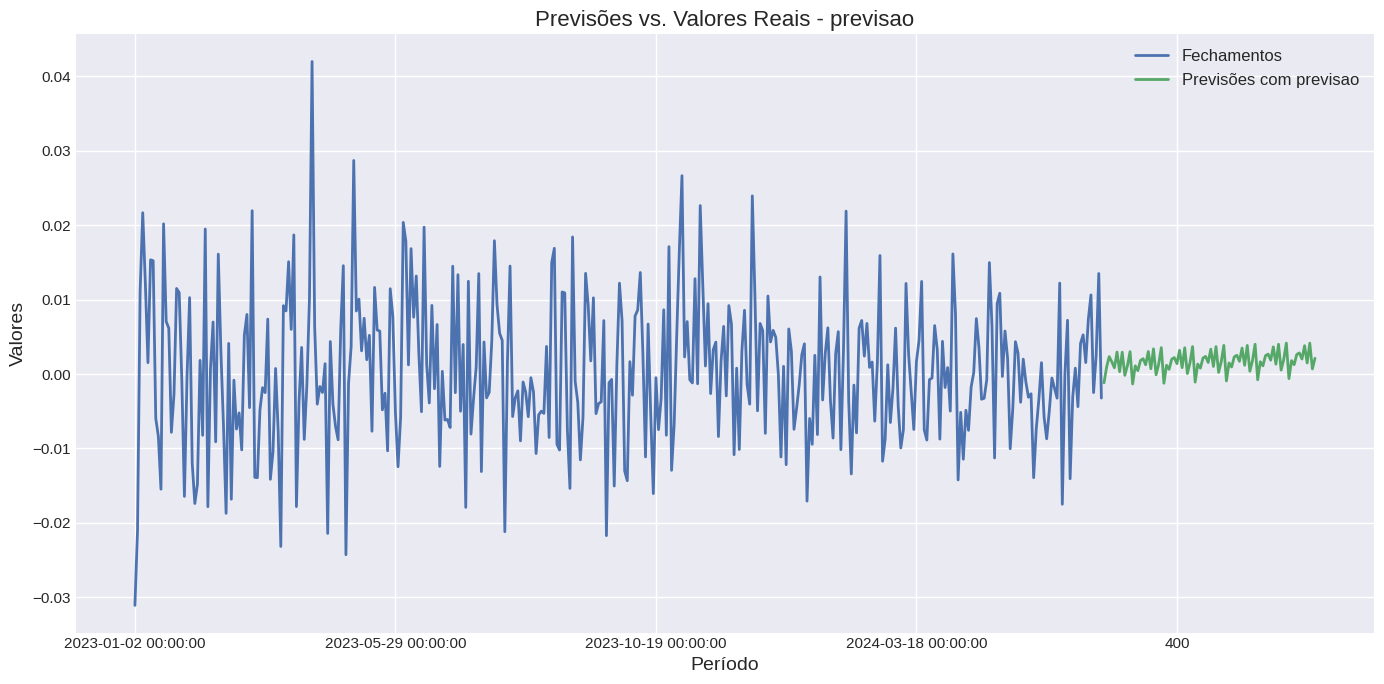

In [ ]:
# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Primeiro gráfico com previsao_df
fig1, ax1 = plt.subplots(figsize=(14, 7))  # Tamanho mais razoável
pd.concat([train_diff2, previsao_df], axis=1).plot(ax=ax1, linewidth=2, color=['b', 'r'])
ax1.legend(['Fechamentos', 'Previsões com previsao_df'], fontsize=12)
ax1.set_xlabel('Período', fontsize=14)
ax1.set_ylabel('Valores', fontsize=14)
ax1.set_title('Previsões vs. Valores Reais - previsao_df', fontsize=16)

# Exibir o primeiro gráfico
plt.tight_layout()
plt.show()

# Segundo gráfico com previsao
fig2, ax2 = plt.subplots(figsize=(14, 7))  # Tamanho mais razoável
pd.concat([train_diff2, previsao], axis=1).plot(ax=ax2, linewidth=2, color=['b', 'g'])
ax2.legend(['Fechamentos', 'Previsões com previsao'], fontsize=12)
ax2.set_xlabel('Período', fontsize=14)
ax2.set_ylabel('Valores', fontsize=14)
ax2.set_title('Previsões vs. Valores Reais - previsao', fontsize=16)

# Exibir o segundo gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Calcular MSE
mse = mean_squared_error(teste_aa, previsao_df['Último'])

# Calcular MAE
mae = mean_absolute_error(teste_aa, previsao_df['Último'])

# Calcular MAPE
epsilon = 1e-10
mape = np.mean(np.abs((teste_aa - previsao_df) / (teste_aa + epsilon))) * 100

# Exibir os resultados
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MSE: 5.747380611462667e-05
MAE: 0.00619605687721386
MAPE: 223.58341958045253%


Após o ajuste do AutoARIMA, o MSE de 5.747 e-05 e o MAE de aproximadamente 0,006 indicam uma melhora significativa na precisão das previsões, com erros muito baixos. No entanto, o MAPE de 223,58% sugere que, em média, as previsões têm um erro percentual muito alto em relação aos valores reais, o que pode ocorrer devido a valores reais próximos de zero. Isso indica que, embora o modelo esteja fazendo previsões precisas em termos absolutos, ele pode não estar capturando bem a variação relativa dos dados.

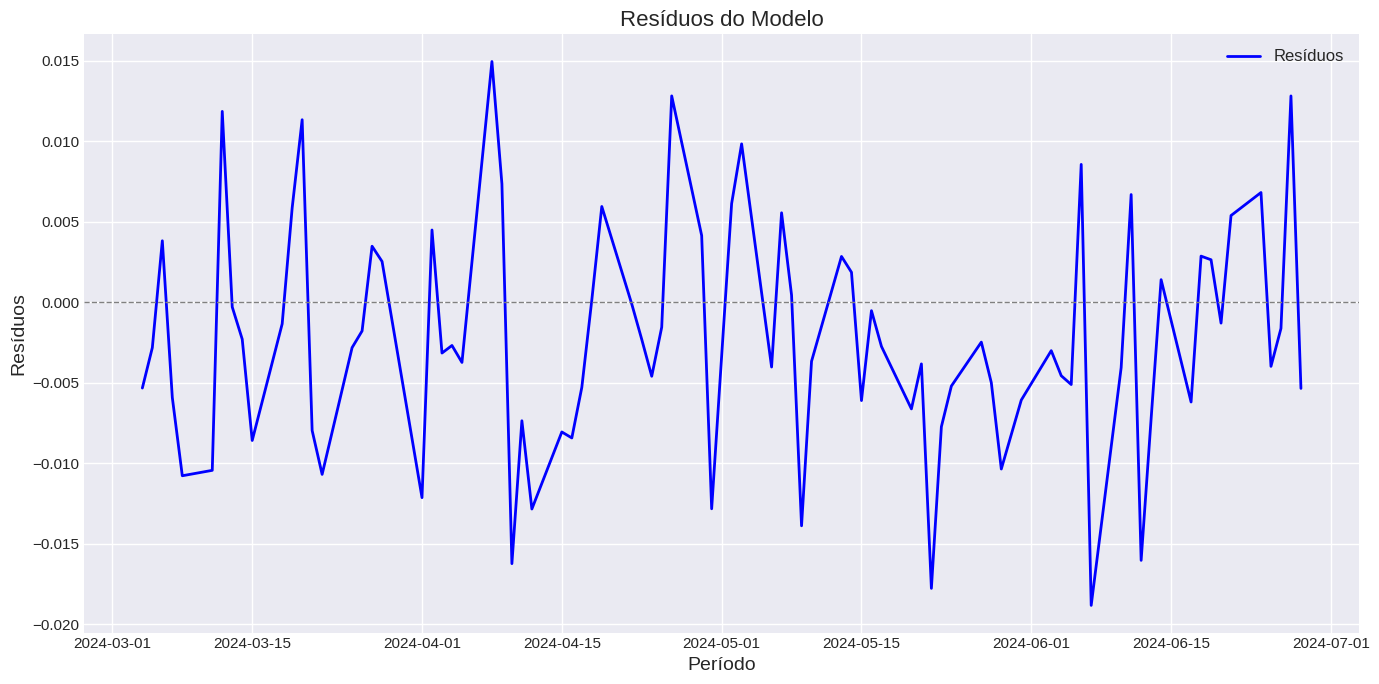

In [ ]:
# Calcula os resíduos
residuos = teste_aa['Último'].iloc[:periodo] - previsao_df['Último']

# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Cria a figura para os resíduos
plt.figure(figsize=(14, 7))

# Plota os resíduos
plt.plot(residuos, color='blue', linewidth=2, label='Resíduos')

# Adiciona linha horizontal em y=0 para referência
plt.axhline(y=0, linestyle='--', color='gray', linewidth=1)

# Ajusta o título e os rótulos dos eixos
plt.title('Resíduos do Modelo', fontsize=16)
plt.xlabel('Período', fontsize=14)
plt.ylabel('Resíduos', fontsize=14)

# Adiciona uma legenda
plt.legend(fontsize=12)

# Melhora o layout
plt.tight_layout()

# Exibe o gráfico
plt.show()

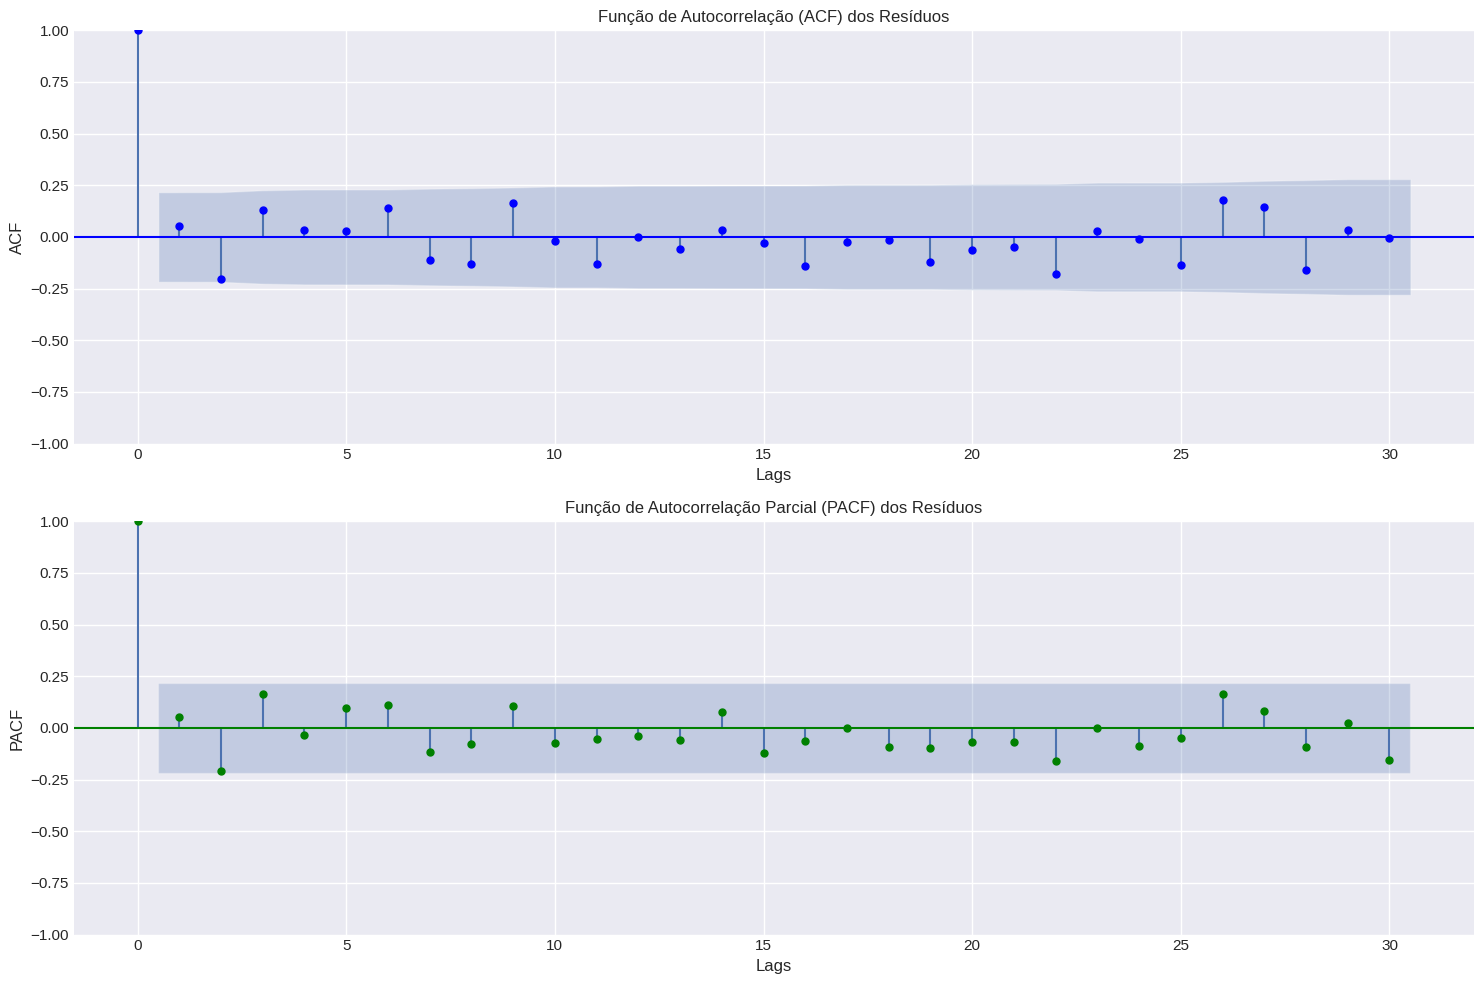

In [ ]:
# Calcula os resíduos
residuos = teste_aa['Último'].iloc[:periodo] - previsao_df['Último']

# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Cria a figura para ACF e PACF
plt.figure(figsize=(15, 10))

# Gráfico da Função de Autocorrelação (ACF)
plt.subplot(2, 1, 1)
plot_acf(residuos, lags=30, ax=plt.gca(), color='blue', title='Função de Autocorrelação (ACF) dos Resíduos')
plt.xlabel('Lags', fontsize=12)
plt.ylabel('ACF', fontsize=12)

# Gráfico da Função de Autocorrelação Parcial (PACF)
plt.subplot(2, 1, 2)
plot_pacf(residuos, lags=30, ax=plt.gca(), color='green', title='Função de Autocorrelação Parcial (PACF) dos Resíduos')
plt.xlabel('Lags', fontsize=12)
plt.ylabel('PACF', fontsize=12)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe o gráfico
plt.show()

### Modelo SARIMAX com Característica Var%

Decidimos testar o SARIMAX para incorporar a "Variação" como uma variável exógena, na esperança de capturar melhor a dinâmica dos dados e reduzir o MAPE elevado observado com o autoARIMA. O SARIMAX permite modelar a influência de fatores externos, como a "Variação", proporcionando uma análise mais completa e potencialmente melhorando a precisão das previsões ao considerar mais informações relevantes.

In [ ]:
import statsmodels.api as sm

In [ ]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred) ** 2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape

# Função para imprimir métricas
def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")

Usando a base a partir de janeiro de 2023 - Utiliza a variável train_diff (série diferenciada) sem os dados sintéticos de train_diff_sint


In [ ]:
# Dados com o ultimo sem diferenciação
train_diff2 = dados.loc[dados.index > '2023-01-01', ['Último', 'Var%']]
train_sarimax = train_diff2.dropna()

In [ ]:
train_sarimax['Var%'] = train_sarimax['Var%'].replace(',', '.', regex=True)
train_sarimax['Var%'] = train_sarimax['Var%'].replace('[^\d\.]', '', regex=True).astype(float)
train_sarimax.head()

,Último,Var%
Data,,
2023-01-02,106376,3.06
2023-01-03,104166,2.08
2023-01-04,105334,1.12
2023-01-05,107641,2.19
2023-01-06,108964,1.23


#### Divisão em treino e teste

In [ ]:
# Definir variáveis de treino e teste
treino_sarimax_ultimo = train_sarimax.loc[train_sarimax.index < '2024-03-01', 'Último']
teste_sarimax_ultimo = train_sarimax.loc[train_sarimax.index >= '2024-03-01', 'Último']

treino_sarimax_var = train_sarimax.loc[train_sarimax.index < '2024-03-01', 'Var%']
teste_sarimax_var = train_sarimax.loc[train_sarimax.index >= '2024-03-01', 'Var%']

In [ ]:
teste_sarimax_ultimo.index[:30]

DatetimeIndex(['2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06',
               '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18',
               '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22',
               '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28',
               '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04',
               '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10',
               '2024-04-11', '2024-04-12'],
              dtype='datetime64[ns]', name='Data', freq=None)

#### Validação do modelo

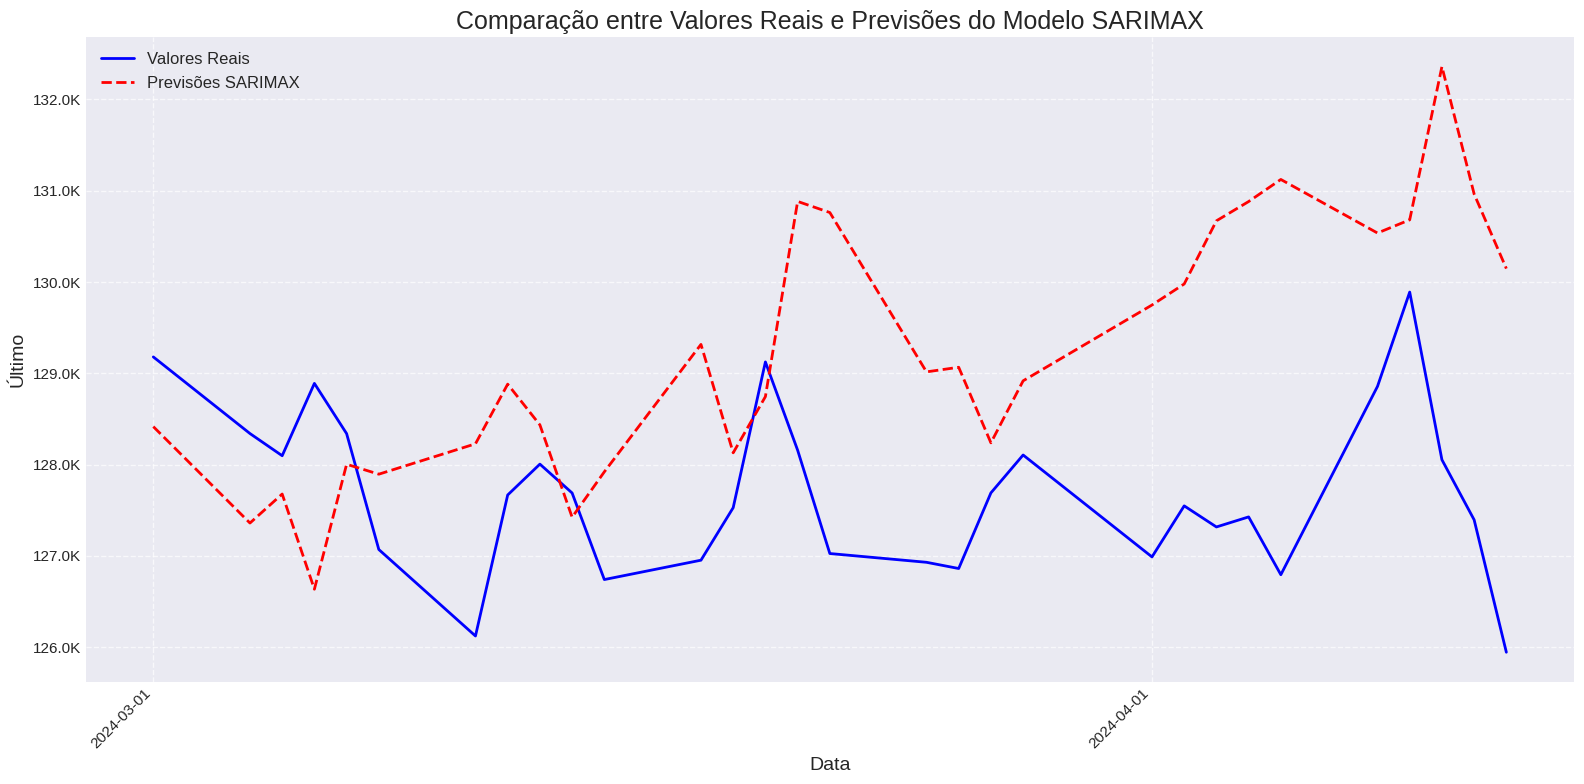



SARIMAX Metrics:
MAE: 1902.8919625508788
MSE: 5350782.7445759075
MAPE: 1.4937721679334748%


In [ ]:
# Define a função de formatação para milhares e milhões
def format_thousands(x, pos):
    """
    Formata números em milhares (K) e milhões (M) para o eixo y.
    """
    if x >= 1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.1f}K'
    elif x <= -1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x <= -1_000:
        return f'{x * 1e-3:.1f}K'
    else:
        return f'{x:.0f}'

# Parâmetros
dias = 30

# Dados
exog_train = treino_sarimax_var
exog_test = teste_sarimax_var

warnings.filterwarnings('ignore')

# Modelo SARIMAX
model = sm.tsa.statespace.SARIMAX(
    treino_sarimax_ultimo, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30)
)
results = model.fit(disp=False)

# Previsões
forecast = results.get_forecast(steps=dias, exog=exog_test[:dias])
preds = forecast.predicted_mean

# Garantir que a previsão tenha o mesmo índice que o teste
preds = pd.Series(preds.values, index=teste_sarimax_ultimo.index[:dias], name='predicted_mean')

# Plotar os resultados
plt.figure(figsize=(16, 8))

# Plotar valores reais
plt.plot(teste_sarimax_ultimo.index[:dias], teste_sarimax_ultimo[:dias], label='Valores Reais', color='blue', linewidth=2)

# Plotar previsões
plt.plot(preds.index, preds, label='Previsões SARIMAX', color='red', linestyle='--', linewidth=2)

# Adicionar título e legendas
plt.title('Comparação entre Valores Reais e Previsões do Modelo SARIMAX', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Último', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Aplica a função de formatação ao eixo y
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Melhora a formatação das datas no eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45, ha='right')

# Ajusta o layout
plt.tight_layout()
plt.show()

# Calcular e exibir métricas
metrics_sarimax = calculate_metrics(teste_sarimax_ultimo, preds)
print("\n\nSARIMAX Metrics:")
print_metrics(metrics_sarimax)

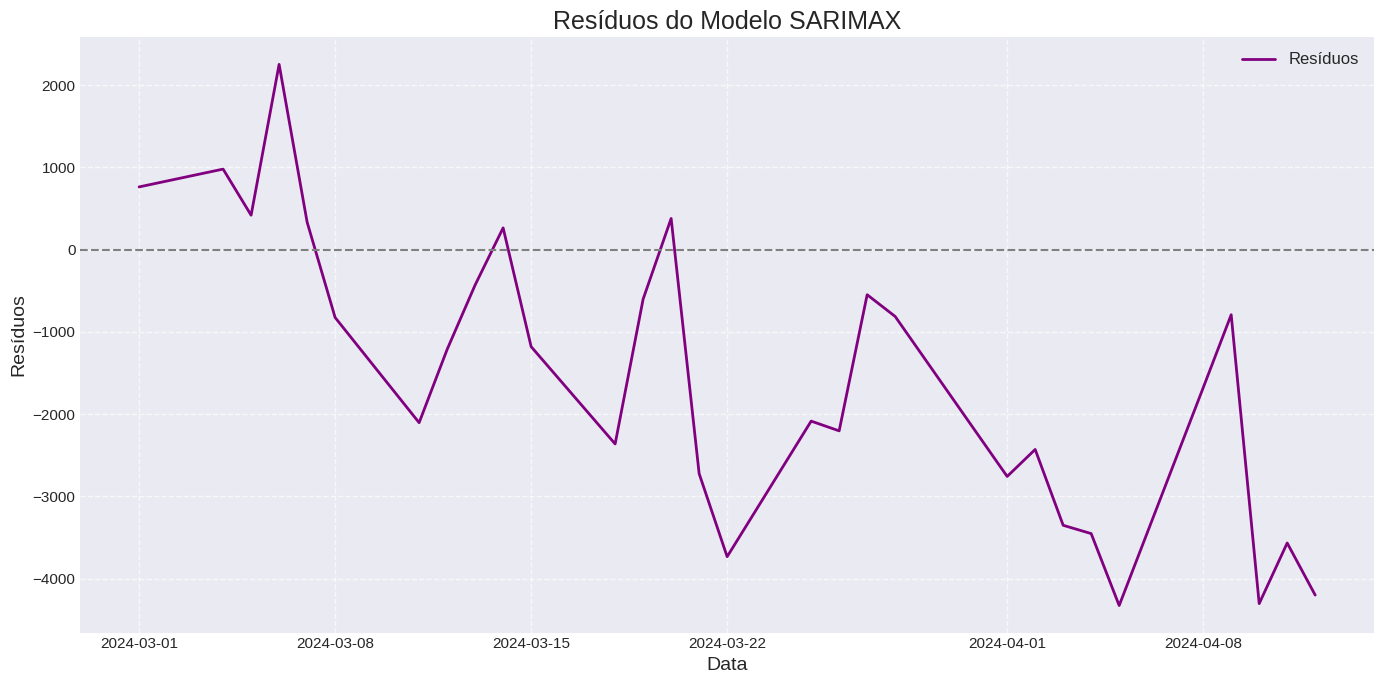

In [ ]:
# Calcula os resíduos
residuos = teste_sarimax_ultimo - preds

# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Cria a figura para os resíduos
plt.figure(figsize=(14, 7))

# Plota os resíduos
plt.plot(residuos, color='purple', linewidth=2, label='Resíduos')

# Linha horizontal em y=0
plt.axhline(y=0, linestyle='--', color='gray', linewidth=1.5)

# Adiciona título e rótulos
plt.title('Resíduos do Modelo SARIMAX', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Resíduos', fontsize=14)
plt.legend(fontsize=12)

# Adiciona uma grade para melhor leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Ajusta o layout para melhor apresentação
plt.tight_layout()

# Exibe o gráfico
plt.show()

O MAE e o MSE indicam erros relativamente altos em termos absolutos, sugerindo que as previsões podem estar distantes dos valores reais. No entanto, o MAPE muito baixo indica que o modelo está capturando bem a variação percentual dos dados.

O gráfico de resíduos, mostrando um leve padrão de declínio e dados um pouco distantes da linha zero a partir da metade, sugere que há algum padrão não totalmente capturado pelo modelo.

### Modelo XGBoost com Característica Var%

Escolhemos testar o XGBoost, um modelo de árvore de decisão, para explorar sua capacidade de capturar relações não lineares e complexas nos dados, especialmente com a inclusão da "Variação" como variável exógena. Enquanto SARIMAX lida bem com padrões lineares e sazonais, o XGBoost pode capturar interações mais sutis e padrões complexos que os modelos anteriores não conseguiram modelar adequadamente, potencialmente melhorando a precisão das previsões.

In [ ]:
import xgboost as xgb

In [ ]:
train_diff2 = dados.loc[dados.index > '2023-01-01']
train_xgboost = train_diff2.dropna()

In [ ]:
train_xgboost['Var%'] = train_xgboost['Var%'].replace(',', '.', regex=True)
train_xgboost['Var%'] = train_xgboost['Var%'].replace('[^\d\.]', '', regex=True).astype(float)


train_xgboost['Vol.'] = train_xgboost['Vol.'].replace(',', '.', regex=True)
train_xgboost['Vol.'] = train_xgboost['Vol.'].replace('[^\d\.]', '', regex=True).astype(float)
train_xgboost.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,ref,mes,ano,dia
Data,,,,,,,,,,
2023-01-02,106376,109734,109734,105981,8.13,3.06,2023-01-02,1,2023,2
2023-01-03,104166,106377,106684,103852,14.47,2.08,2023-01-03,1,2023,3
2023-01-04,105334,104167,105627,103915,14.45,1.12,2023-01-04,1,2023,4
2023-01-05,107641,105336,107743,105333,15.51,2.19,2023-01-05,1,2023,5
2023-01-06,108964,107642,109433,107642,12.63,1.23,2023-01-06,1,2023,6


#### Separação em treino e teste

In [ ]:
# Definir variáveis de treino e teste
treino_xgboost = train_xgboost.loc[train_xgboost.index < '2024-03-01']
teste_xgboost = train_xgboost.loc[train_xgboost.index >= '2024-03-01']

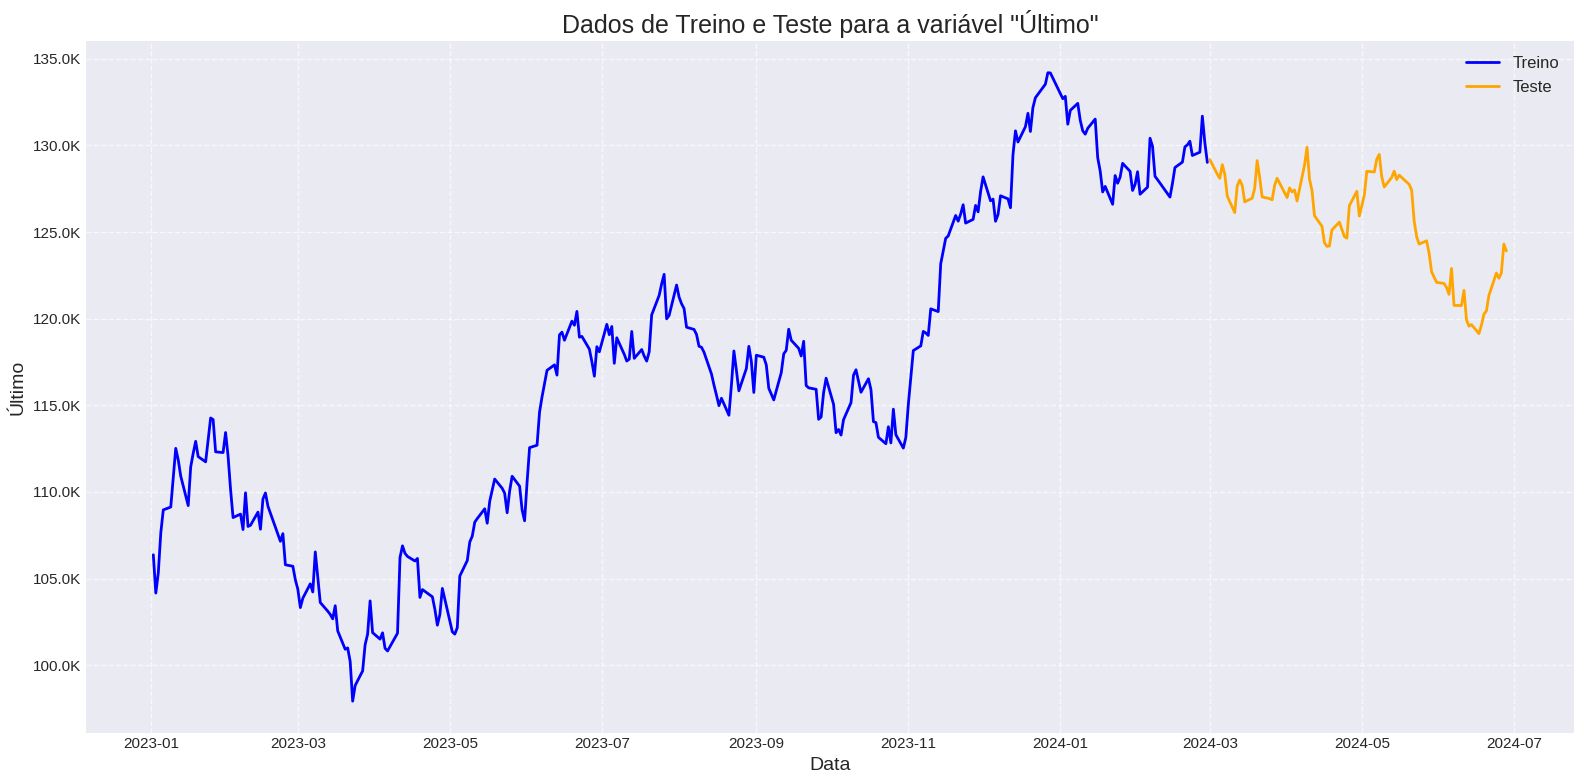

In [ ]:
# Define a função de formatação para milhares e milhões
def format_thousands(x, pos):
    """
    Formata números em milhares (K) e milhões (M) para o eixo y.
    """
    if x >= 1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.1f}K'
    elif x <= -1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x <= -1_000:
        return f'{x * 1e-3:.1f}K'
    else:
        return f'{x:.0f}'

# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Cria a figura para os dados de treino e teste
plt.figure(figsize=(16, 8))

# Plota os dados de treino e teste
plt.plot(treino_xgboost.index, treino_xgboost['Último'], label='Treino', color='blue', linewidth=2)
plt.plot(teste_xgboost.index, teste_xgboost['Último'], label='Teste', color='orange', linewidth=2)

# Adiciona título e rótulos
plt.title('Dados de Treino e Teste para a variável "Último"', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Último', fontsize=14)

# Adiciona a legenda
plt.legend(fontsize=12)

# Adiciona uma grade para melhor leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Aplica a função de formatação ao eixo y
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Ajusta o layout para melhor apresentação
plt.tight_layout()

# Exibe o gráfico
plt.show()

Definição das variáveis independentes e da variável alvo

In [ ]:
FEATURES = ["Abertura","mes", "ano", "dia"]
TARGET = "Último"

In [ ]:
X_train, y_train = treino_xgboost[FEATURES], treino_xgboost[TARGET]
X_test, y_test = teste_xgboost[FEATURES], teste_xgboost[TARGET]

reg = xgb.XGBRegressor(n_estimators=100)

reg = xgb.train(
    params=reg.get_xgb_params(),
    dtrain=xgb.DMatrix(X_train, y_train),
    num_boost_round=reg.get_params()['n_estimators'],
    evals=[(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'test')],
    early_stopping_rounds=50,
    verbose_eval=False
)

#### Validação do modelo

<Figure size 1200x800 with 0 Axes>

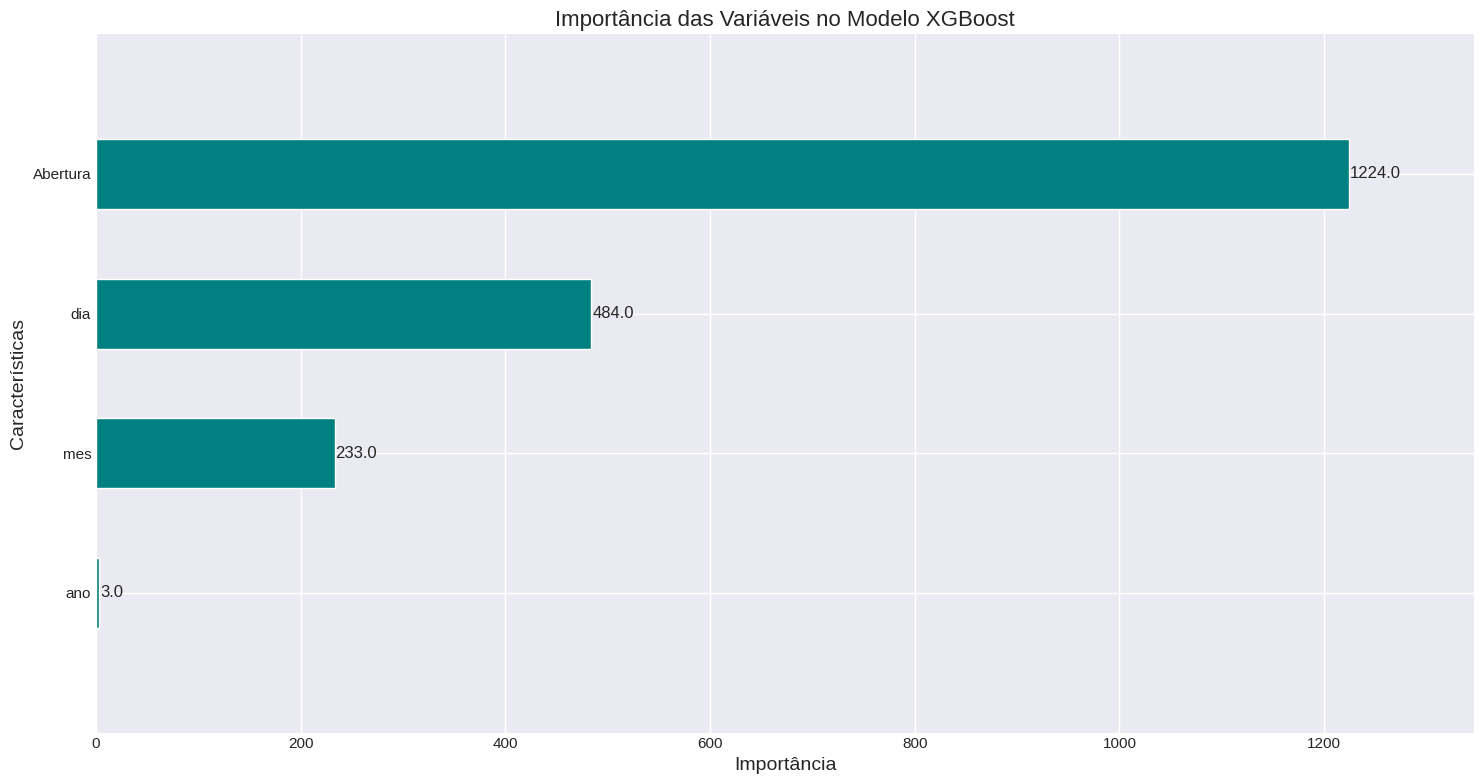

In [ ]:
# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Cria a figura para a importância das variáveis
plt.figure(figsize=(12, 8))

# Plota a importância das variáveis
xgb.plot_importance(
    reg,
    importance_type='weight',  # Tipo de importância a ser exibida (weight, gain, cover)
    max_num_features=10,       # Número máximo de características a serem exibidas
    height=0.5,                # Altura de cada barra
    title='Importância das Variáveis no Modelo XGBoost',
    xlabel='Importância',
    ylabel='Características',
    grid=True,                 # Adiciona uma grade para melhor leitura
    color='teal'               # Cor das barras
)

# Ajusta o título e a exibição
plt.title('Importância das Variáveis no Modelo XGBoost', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Características', fontsize=14)
plt.tight_layout()

# Exibe o gráfico
plt.show()

"Abertura" é a característica mais influente nas previsões do modelo, enquanto "Ano" contribui pouco para o desempenho do modelo.

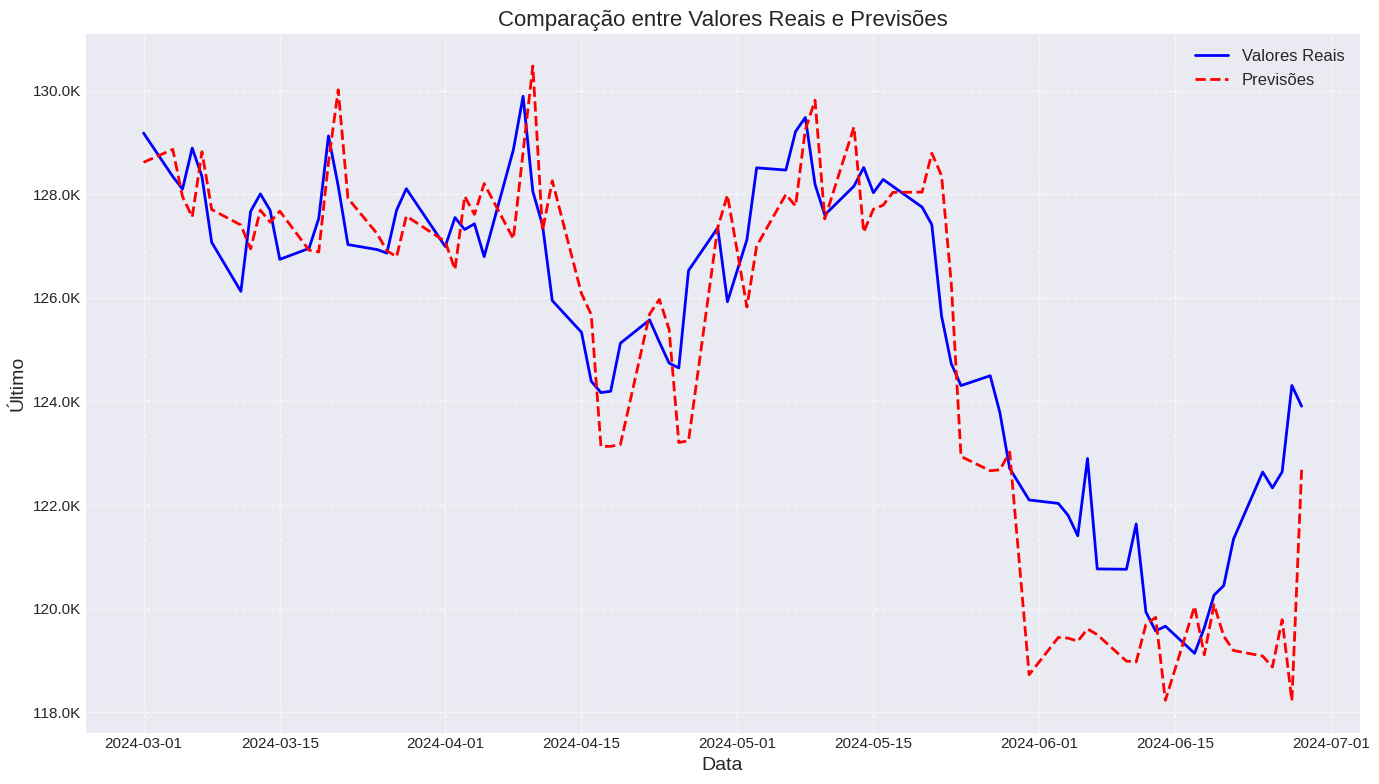

XGBoost Metrics:
MAE: 1229.2981927710844
MSE: 2634552.508005165
MAPE: 0.9853889386520265%


In [ ]:

# Define a função de formatação para milhares (K) e milhões (M)
def format_thousands(x, pos):
    """
    Formata números em milhares (K) e milhões (M) para o eixo y.
    """
    if x >= 1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.1f}K'
    elif x <= -1_000_000:
        return f'{x * 1e-6:.1f}M'
    elif x <= -1_000:
        return f'{x * 1e-3:.1f}K'
    else:
        return f'{x:.0f}'

# Realiza a previsão com o modelo XGBoost
preds = reg.predict(xgb.DMatrix(X_test))

# Configurações do estilo
plt.style.use('seaborn-darkgrid')

# Cria a figura para a comparação
plt.figure(figsize=(14, 8))

# Plota os valores reais
plt.plot(y_test.index, y_test, label='Valores Reais', color='blue', linestyle='-', linewidth=2)

# Plota as previsões
plt.plot(y_test.index, preds, label='Previsões', color='red', linestyle='--', linewidth=2)

# Adiciona título e rótulos
plt.title('Comparação entre Valores Reais e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Último', fontsize=14)

# Adiciona a legenda
plt.legend(fontsize=12)

# Adiciona uma grade para melhor leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Aplica a função de formatação ao eixo y
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Ajusta o layout para melhor apresentação
plt.tight_layout()

# Exibe o gráfico
plt.show()

# Calcula e exibe as métricas
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

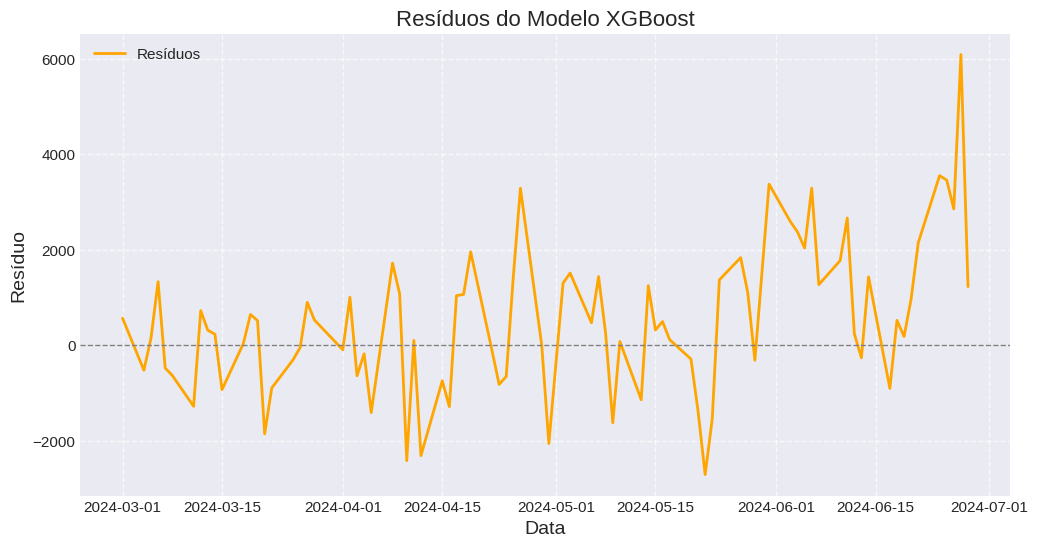

In [ ]:
# Calcula os resíduos
residuos = y_test - preds

# Configura o gráfico
plt.figure(figsize=(12, 6))

# Plota os resíduos
plt.plot(y_test.index, residuos, label='Resíduos', color='orange', linestyle='-', linewidth=2)

# Adiciona uma linha horizontal no zero
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Ajusta o título e os rótulos
plt.title('Resíduos do Modelo XGBoost', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Resíduo', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Exibe o gráfico
plt.show()

O MAE e o MSE indicam erros médios e variabilidade consideráveis nas previsões, com um MAE de 1229,30 e um MSE de 2.634.552,51. No entanto, o MAPE muito baixo de 0,99% sugere que, em termos percentuais, o modelo tem uma precisão excelente. Além disso, o gráfico de resíduos mostra um bom desempenho, com os valores oscilando perto de zero e sem padrões evidentes, o que reforça a robustez da precisão relativa do modelo, apesar dos erros absolutos.

Nossa próxima opção seria o modelo Prophet, mas como ele foi descontinuado e não recebe atualizações há algum tempo, decidimos não usá-lo.

### Conclusão

**ARIMA:**

MSE: 1.358.608,88

MAE: 950,72

MAPE: 10,31%

O ARIMA apresenta um MAE e MSE relativamente baixos e um MAPE moderado, indicando previsões razoavelmente precisas com alguns erros.

**AutoARIMA:**

MSE: 5.747 e-0.5

MAE: 0,006

MAPE: 223,58%

O AutoARIMA tem um MSE e MAE muito baixos, sugerindo previsões precisas em termos absolutos. No entanto, o MAPE muito alto indica problemas na precisão percentual, possivelmente devido a valores reais próximos de zero.


**SARIMAX:**

MSE: 5.350.782,74

MAE: 1902,89

MAPE: 1,49%

O SARIMAX tem um MSE e MAE relativamente altos, mas um MAPE muito baixo, mostrando boa precisão percentual apesar dos erros absolutos maiores.


**XGBoost:**

MSE: 2.634.552,51

MAE: 1229,30

MAPE: 0,99%

O XGBoost apresenta um MSE e MAE significativos, mas com um MAPE muito baixo, indicando alta precisão percentual, mas com erros absolutos consideráveis.

**Resumindo**

O AutoARIMA tem a melhor performance em termos absolutos, mas problemas com a precisão percentual.

O SARIMAX mostra boa precisão percentual, mas com erros absolutos maiores.

O XGBoost tem uma precisão percentual excelente, mas também apresenta erros absolutos significativos.

O ARIMA oferece um bom equilíbrio entre erros absolutos e percentuais, com uma performance geral razoável.

> XGBoost parece ser o modelo mais próximo do ideal, pois apresenta um MAPE muito baixo (0,99%), indicando alta precisão percentual, e o gráfico de resíduos sugere que o modelo está capturando bem a dinâmica da série temporal, com erros relativamente pequenos e sem padrões evidentes nos resíduos. Embora o MAE e o MSE sejam maiores em comparação com outros modelos, a alta precisão percentual e a análise dos resíduos tornam o XGBoost uma escolha robusta para previsões diárias do fechamento da base da IBOVESPA.

